In [1]:
import pandas as pd
import numpy as np
import cobra
import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns
from CBModellingFuncs import *
import os
from multiprocessing import Pool
from matplotlib.ticker import MaxNLocator

from statsmodels.sandbox.stats.multicomp import multipletests
import threadpoolctl
import time
import matplotlib

processes = 50
threadpoolctl.threadpool_limits(limits=processes)

cobra_config = cobra.Configuration()
cobra_config.solver = "cplex"
cobra_config.tolerance = 1e-6

In [2]:
model, m_warnings = cobra.io.validate_sbml_model("../results/AdaptediMT1026v3.xml")

rgdict = {}
for g in model.groups:
    for r in g.members:
        
        rgdict[r.id] = g.id.title()

SBML errors in validation, check error log for details.
COBRA errors in validation, check error log for details.
COBRA warnings in validation, check error log for details.


In [3]:
DRinfo = pd.read_csv(f"../results/dataframes/DerivedRetentInfo.csv", index_col=0, header=[0,1])
IRinfo = pd.read_csv(f"../results/dataframes/InterpolatedRetentInfo.csv", index_col=0, header=[0,1])
FRinfo = pd.read_csv(f"../results/dataframes/FittedRetentInfo.csv", index_col=0, header=[0,1])

NGAMseries = pd.read_csv('../results/dataframes/NGAMseries.csv',index_col=0,squeeze=True)

model_viab_cols = ["Growth Rate model 1/h", "qS model mmol/gh","qP model g/gh", "qCO2 viable model mmol/gh", "qO2 viable model mmol/gh", "qStorGlyc mmol/gh"]
viab_cols = ["Average Growth Rate 1/h", "qS viable mmol/gh","qP g/gh", "qCO2 viable mmol/gh", "qO2 viable mmol/gh", "qStorGlyc mmol/gh"] 

sp_gr = {'C0.1': '0.1',
         '0.0': '0.025',
         '0.9': '0.013',
         '1.9': '0.0073',
         '5.9': '0.0022',
         '7.9': '0.0017',
         '9.9': '0.0014',
         '13.9': '0.001',
         '16.9': '0.00083',
         '19.9': '0.00071',
         '23.9': '0.00059',
         '27.9': '0.00052'}

## Sampling

Generate chains for each different biomass equation at each different point during the retentostat cultivation

In [4]:
co2=True
optthin = 1000
o2 = True
n_chains = 4

In [ ]:
%%time

sampling_results = []
all_fva = []

equation_names = ["Consensus", "Derived", "Interpolated", "Fitted","ScaledConsensus"]
datasets = [DRinfo, DRinfo, IRinfo, FRinfo, DRinfo]


for i, equation in enumerate(equation_names):
    data = datasets[i].loc[:, model_viab_cols].copy()

    for name, values in data.iterrows():
        
        loop_start = time.time()
        print(name)
        mu = values[0]
        sd = values[1]

        with model as temp_model:
            set_biomass_objective(temp_model, equation, name)
            print(f"{equation} - {name}")
            
            temp_model.reactions.ATPM.bounds = (NGAMseries[f"{equation}"],1000)
            
 
            solution = constrain_predict(temp_model, values, co2=co2, o2=o2)
            pred_mu = solution.objective_value

            if equation in ["Consensus", "ScaledConsensus"]:
                temp_model.reactions.get_by_id(equation).bounds =  (pred_mu*0.95, pred_mu)
                
            else:
                temp_model.reactions.get_by_id(f"{equation}Biomass{name}").bounds = (pred_mu*0.95, pred_mu) 
               
            flux_span = constrain_predict(temp_model, values, co2=co2, fluxva=True, processes=processes,fopt=0)
            remove_blocked(temp_model, flux_span, solution)


            fva_frame = flux_span.stack(0).to_frame().T
            fva_frame["Equation"] = equation
            fva_frame["Time"] = name
            fva_frame.set_index(["Equation", "Time"], inplace=True)
            all_fva.append(fva_frame)
            
            chains = constrain_predict(temp_model, values, sampling=True, chains=n_chains, thinning=optthin, 
                                       loopless=True, processes=processes, co2=co2, o2=o2, n_samples=1250)#5000)

                 # ensure all have same number of samples, may have
            chains = [df.iloc[:min([df.shape[0] for df in chains]), :] for df in chains]
            print(f"{equation} chains with all have length of {chains[0].shape[0]}") 

            for j, chain in enumerate(chains):
            
                chain["Chain"] = j+1
            chains = pd.concat(chains, ignore_index=True)
            chains.to_pickle(f"../results/sampling/{equation}_{name}_T{optthin}.pkl.gz", 
                                compression={'method': 'gzip', 'compresslevel': 6, 'mtime': 1})

            now = time.time()
            print(f"It has been {(now - loop_start)/60} minutes since the {name} sampling point loop started")
####

all_fva = pd.concat(all_fva)
gr_values = all_fva.index.get_level_values(1).to_series().apply(lambda x: sp_gr[x]).values
gr_values = pd.Series(gr_values.astype(float), name="Growth Rate")
all_fva.set_index(gr_values, append=True, inplace=True)
all_fva.to_csv(f"../results/dataframes/FVA_ranges.csv")

7.9
Consensus - 7.9
2483 reactions before making consistent, 1453 after
It has been 6.474026687939962 minutes since the 7.9 sampling point loop started
7.9
ScaledDerived - 7.9
2483 reactions before making consistent, 1444 after
It has been 6.316961018244426 minutes since the 7.9 sampling point loop started
7.9
ScaledInterpolated - 7.9
2483 reactions before making consistent, 1438 after


Process ForkPoolWorker-1836:
Process ForkPoolWorker-1810:
Process ForkPoolWorker-1832:
Process ForkPoolWorker-1845:
Process ForkPoolWorker-1825:
Process ForkPoolWorker-1813:
Process ForkPoolWorker-1815:
Process ForkPoolWorker-1828:
Process ForkPoolWorker-1812:
Process ForkPoolWorker-1850:
Process ForkPoolWorker-1821:
Process ForkPoolWorker-1820:
Process ForkPoolWorker-1822:
Process ForkPoolWorker-1814:
Process ForkPoolWorker-1824:
Process ForkPoolWorker-1833:
Process ForkPoolWorker-1817:
Process ForkPoolWorker-1811:
Process ForkPoolWorker-1848:
Process ForkPoolWorker-1806:
Process ForkPoolWorker-1847:
Process ForkPoolWorker-1823:
Process ForkPoolWorker-1849:
Process ForkPoolWorker-1816:
Process ForkPoolWorker-1834:
Process ForkPoolWorker-1846:
Process ForkPoolWorker-1804:
Process ForkPoolWorker-1830:
Process ForkPoolWorker-1803:
Process ForkPoolWorker-1819:
Process ForkPoolWorker-1805:
Process ForkPoolWorker-1802:
Process ForkPoolWorker-1807:
Process ForkPoolWorker-1818:
Process ForkPo

# Analysis of sampled chains

## Convergence check

In [5]:
%%time
all_stats = pd.DataFrame()


equation_names = ["Consensus", "Derived", "Interpolated", "Fitted","ScaledConsensus"]
datasets = [DRinfo, DRinfo, IRinfo, FRinfo, DRinfo]

n_chains = 4

for i, equation in enumerate(equation_names):
    data = datasets[i].loc[:, model_viab_cols].copy()
    all_df = []

    for name, values in data.iterrows():
        
        
        chains = pd.read_pickle(f"../results/sampling/{equation}_{name}_T{optthin}.pkl.gz") 
        chains = [chains.set_index("Chain").loc[j+1].reset_index(drop=True) for j in range(n_chains)]
        

        grouped, rxns = extractchains(chains)
        
        for_pool = list(zip(grouped,rxns))
        pool = Pool(processes=processes)
        all_series = pool.starmap(calculateDiagnostics, for_pool)
        pool.close()
        df = pd.concat(all_series,axis=1).T
        df["Equation"] = name
        
        all_df.append(df)
    all_df = pd.concat(all_df, ignore_index=True)
    all_df["Method"] = equation
    
    all_stats = pd.concat([all_stats, all_df], ignore_index=True)
      
n_grouped_chains = all_stats.groupby(["Method", "Equation"]).count()["Rxn"]

all_stats.set_index(["Method", "Equation", "Rxn"], inplace=True)
all_stats["Rhat Fails"] = all_stats["Rhat"] > 1.01
all_stats["ESS-Bulk Fails"] = all_stats["ESS-Bulk"] < 400


summary_stats = all_stats.copy() #all_stats[["Geweke Fails","ESS Split Fails", "Rhat Fails", "ESS-Bulk Fails"]]
summary_stats.index = summary_stats.index.reorder_levels(["Rxn", "Method", "Equation"])#-1,0,1])

chain_summary = (summary_stats > 0).groupby(["Method", "Equation"]).sum()
# chain_summary = chain_summary[["Geweke Fails","ESS Split Fails", "Rhat Fails", "ESS-Bulk Fails"]]
chain_summary = chain_summary[["Geweke Fails","Rhat Fails", "ESS-Bulk Fails"]]
temp_df = (chain_summary.divide(n_grouped_chains, axis=0) * 100)

# temp_df.columns=["% Geweke Fails","% seperated-ESS Fails","% Rhat Fails","% bulk-ESS Fails"]
temp_df.columns=["% Geweke Fails","% Rhat Fails","% bulk-ESS Fails"]

chain_summary = pd.concat([chain_summary,temp_df],axis=1)
chain_summary.to_csv(f"../results/dataframes/SamplingDiagnosticsChainSummaries.csv")

n_method_samples = len(summary_stats.index.droplevel("Rxn").unique())

rxn_summary = summary_stats.copy()

# rxn_summary = rxn_summary[rxn_summary.loc[:,["ESS Split Fails","Rhat Fails", "ESS-Bulk Fails"]].sum(axis=1) > 0]
rxn_summary = rxn_summary[rxn_summary.loc[:,["ESS Split Fails","Rhat Fails", "ESS-Bulk Fails"]].sum(axis=1) > 0]
rxn_summary.to_csv(f"../results/dataframes/SamplingDiagnosticsReactionSummaries.csv")

CPU times: user 44.4 s, sys: 47.6 s, total: 1min 31s
Wall time: 2min 2s


In [6]:
roi = ["G6PDH2","PGI","PYK","MDHm","CSm","AKGMALtm","NADH2_u6cm","NADH2_u6mh","CYOR_u6m","CYOOm","ATPS3m","ATPM"]
rxn_summary.loc[roi]

Geweke Fails      Rhat ESS Split Fails  \
Rxn        Method       Equation                                          
G6PDH2     Interpolated C0.1                2  1.023718               0   
                        0.9                 4  1.011716               2   
                        9.9                 4  1.006785               3   
PGI        Interpolated C0.1                2  1.023737               0   
                        0.9                 4  1.011701               2   
                        9.9                 4  1.007049               3   
PYK        Derived      C0.1                4  1.013292               0   
           Interpolated C0.1                0  1.032472               0   
                        7.9                 0   1.00408               1   
                        9.9                 4   1.00569               3   
MDHm       Consensus    0.0                 3  1.013603               0   
                        19.9                2  1.011667               0   
           Derived      23.9                3  1.013743               0   
           Interpolated 9.9                 4  1.005783               3   
           Fitted       5.9                 1  1.017169               0   
                        16.9                1  1.010611               0   
CSm        Derived      C0.1                4  1.011081               0   
           Interpolated C0.1                0  1.034555               1   
                        9.9                 4  1.007803               4   
AKGMALtm   Consensus    0.0                 3  1.011303               0   
                        19.9                2  1.011384               0   
           Derived      23.9                3  1.013155               0   
           Interpolated C0.1                1   1.01024               0   
                        9.9                 4   1.00568               3   
           Fitted       5.9                 1  1.017057               0   
                        16.9                1  1.010001               0   
NADH2_u6cm Consensus    0.0                 3  1.012552               0   
                        19.9                2    1.0113               0   
           Derived      23.9                3  1.012586               0   
           Interpolated 9.9                 4  1.004886               4   
           Fitted       5.9                 1  1.019805               0   
                        16.9                1  1.010493               0   
NADH2_u6mh Consensus    0.0                 2   1.01076               0   
                        19.9                2   1.01097               0   
           Derived      23.9                3  1.011278               0   
           Interpolated 9.9                 4  1.004227               1   
           Fitted       5.9                 1  1.020792               0   
CYOR_u6m   Consensus    19.9                2  1.011794               0   
           Derived      23.9                3  1.013029               0   
           Fitted       5.9                 1  1.013161               0   
                        16.9                1  1.010665               0   
CYOOm      Consensus    19.9                2  1.011794               0   
           Derived      23.9                3  1.013029               0   
           Fitted       5.9                 1  1.013161               0   
                        16.9                1  1.010666               0   
ATPS3m     Consensus    0.0                 3  1.010227               0   
                        19.9                1  1.010873               0   
           Interpolated 9.9                 4  1.003536               3   
           Fitted       5.9                 1   1.02227               0   

                                     ESS-Bulk     ESS-Tail  Rhat Fails  \
Rxn        Method       Equation                                         
G6PDH2     Interpolated C0.1       630.720713  1238.044496 

In [7]:
chain_summary

Geweke Fails  ESS Split Fails  Rhat Fails  \
Method          Equation                                              
Consensus       0.0                843                6          79   
                0.9                805               48          33   
                1.9                541               47          42   
                13.9               736               33          29   
                16.9               910               31          71   
                19.9               891               19         206   
                23.9               754               23          26   
                27.9              1008                9           9   
                5.9                979               42          44   
                7.9                849                7          26   
                9.9                567               24          14   
                C0.1               783               22          10   
Derived         0.0                761               26          29   
                0.9                483               24          26   
                1.9                745                2           5   
                13.9               622               32          18   
                16.9               629               43          29   
                19.9              1021               42          46   
                23.9               802               11          84   
                27.9               828               69         143   
                5.9                581               37          12   
                7.9                635               48           9   
                9.9                610                6          19   
                C0.1               719               12          23   
Fitted          0.0                627               11           9   
                0.9                771               14          12   
                1.9                834               28          43   
                13.9               690               77          30   
                16.9               953               35         246   
                19.9               833               41         358   
                23.9               885                7          32   
                27.9               910               11          18   
                5.9                846                5          66   
                7.9                879               10          41   
                9.9                704               49          75   
                C0.1               792               12          12   
Interpolated    0.0                574                5          30   
                0.9                824               55          80   
                1.9                791               58          39   
                13.9               596               42          21   
                16.9               623               13          25   
                19.9               929               47          56   
                23.9               746               40          37   
                27.9               778               40          29   
                5.9                637               22           9   
                7.9                576               31          21   
                9.9                714              158          29   
                C0.1               511               35         106   
ScaledConsensus 0.0                817               27          34   
                0.9                865               73          35   
                1.9                554                7           5   
                13.9               962               26          46   
                16.9               647               36          13   
                19.9               574                9         327   
                23.9               777            

## Analysis of flux distributions

##### Import all flux prediction results
##### Calculate flux yields
##### Calculate quantiles of the sampling results

In [8]:
all_pfba = pd.read_csv("../results/dataframes/AllpFBA_results.csv", header=[0,1], index_col=0)
all_pfba = all_pfba.T 

gr_values = all_pfba.index.get_level_values(1).to_series().apply(lambda x:sp_gr[x])
gr_values.name = "Growth Rate"

all_pfba.set_index(gr_values,append=True, inplace=True)

norm_pfba = all_pfba.div(all_pfba["Ex_glc_D"].abs(),axis=0)
norm_pfba.sort_index(inplace=True)

all_fva = pd.read_csv(f"../results/dataframes/FVA_ranges.csv",header=[0,1],index_col=[0,1,2])
norm_fva = all_fva.div(all_fva["Ex_glc_D"].abs().mean(axis=1),axis=0)

In [9]:
%%time
import re
all_chains = []


equation_names = ["Consensus", "Derived", "Interpolated", "Fitted","ScaledConsensus"]
datasets = [DRinfo, DRinfo, IRinfo, FRinfo, DRinfo]

for i, equation in enumerate(equation_names):
    data = datasets[i].loc[:, model_viab_cols].copy()
    all_df = []

    for name, values in data.iterrows():
        
        chains = pd.read_pickle(f"../results/sampling/{equation}_{name}_T{optthin}.pkl.gz") 
        merged = chains.drop(columns="Chain")
        chains = [chains.set_index("Chain").loc[j+1].reset_index(drop=True) for j in range(n_chains)]
        
        mask = pd.concat([(chain == 0).all(axis=0) for chain in chains],axis=1).any(axis=1)
        
        merged = merged.loc[:,~mask]
        # remove any samples with very high fluxes
        merged = merged[(merged != 1000).all(axis=1)]
        
        merged["Equation"] = equation
        merged["Time"] = name
        
        all_chains.append(merged)

all_chains_df = pd.concat(all_chains).fillna(0)
all_chains_df.reset_index(inplace=True)
all_chains_df.rename(columns={"index":"Chain"},inplace=True)
all_chains_df["Growth Rate"] = all_chains_df.Time.apply(lambda x: sp_gr[x])
all_chains_df.set_index(["Equation", "Time", "Chain", "Growth Rate"],inplace=True)
all_chains_df = all_chains_df.sort_index(level=-1, ascending=False)
all_chains_df.to_pickle(f"../results/dataframes/AllChains.pkl.gz", compression={'method': 'gzip', 'compresslevel': 6, 'mtime': 1})

quants = all_chains_df.groupby(["Equation", "Time", "Growth Rate"]).quantile([0.025, 0.975]) # [0.0125, 0.9875])
quants = quants.unstack().sort_index(level=["Equation","Growth Rate"],ascending=False)

# Normalise all samples to their glucose uptake rate
norm_chains_df = all_chains_df.div(all_chains_df["Ex_glc_D"].abs(), axis=0)
norm_chains_df.to_pickle(f"../results/dataframes/NormChains.pkl.gz", compression={'method': 'gzip', 'compresslevel': 6, 'mtime': 1})

# Calculate the quantiles
norm_quants = norm_chains_df.groupby(["Equation", "Time", "Growth Rate"]).quantile([0.025, 0.975]) # [0.0125, 0.9875])
norm_quants = norm_quants.unstack().sort_index(level=["Equation","Growth Rate"],ascending=False)
norm_quants.to_csv(f"../results/dataframes/95%CIFluxRatios.csv") 
norm_quants.loc[:, ["G6PDH2", "PGI","PGMT", "TRE6PS", "PFK", 
               "PYK", "PC", "PDHa1", "CSm", "ASPTA",
               "ASPTAm",  "AKGMALtm", "ASPGLU2m",
               "MDH", "MDHm","ME1m" , "Ex_nh4"]].to_csv(f"../results/dataframes/95%CIFluxRatiosInteresting.csv")

CPU times: user 5min 39s, sys: 9.78 s, total: 5min 49s
Wall time: 5min 48s


##### Calculate the production fluxes of cofactors

In [10]:
%%time 

interested_cofactors = ['atp_c', 'nadh_c', 'nadph_c', 'atp_m', 'nadh_m', 'nadph_m',
                      'atp_x', 'nadh_x', 'nadph_x']

sm = cobra.util.array.create_stoichiometric_matrix(model, array_type='DataFrame', dtype=None)

# Calculate total cofactor production, as well as what proportion of the supply comes from which pathway

cofactors_total_supply, cof_rxn_supply = calculate_cofactors(all_chains_df,interested_cofactors,sm, source=True)
cofactors_total_supply = cofactors_total_supply.loc[:,(cofactors_total_supply > 0).any()]
cofactors_ranges = cofactors_total_supply.groupby(["Equation", "Growth Rate"]).quantile([0.025, 0.975]) # 0.0125, 0.9875])
cofactors_ranges = cofactors_ranges.T.stack([0,2])
cofactors_ranges = cofactors_ranges.sort_index(axis=1,ascending=False)
cofactors_ranges.to_csv(f"../results/dataframes/TotalCofactorRanges.csv")

cof_rxn_supply2 = cof_rxn_supply.loc[(~cof_rxn_supply.isna().all(axis=1)),
                                        (~cof_rxn_supply.isna().all())]
cof_rxn_supply2 = cof_rxn_supply2.loc[:,(cof_rxn_supply2 > 1e-6).any()]
subsystem_supply = cof_rxn_supply2.rename(columns=rgdict)
subsystem_supply = subsystem_supply.groupby(subsystem_supply.columns,axis=1).sum()
subsystem_supply = subsystem_supply.T.stack(0)
subsystem_supply.to_csv("../results/dataframes/MajorCofactorsProductionBySubsystems.csv")

cofactors_norm_total_supply = calculate_cofactors(norm_chains_df,interested_cofactors,sm)
cofactors_norm_total_supply = cofactors_norm_total_supply.loc[:,(cofactors_norm_total_supply > 0).any()]
cofactors_norm_ranges = cofactors_norm_total_supply.groupby(["Equation", "Growth Rate"]).quantile([0.025, 0.975]) # 0.0125, 0.9875])
cofactors_norm_ranges = cofactors_norm_ranges.T.stack([0,2])
cofactors_norm_ranges = cofactors_norm_ranges.sort_index(axis=1,ascending=False)
cofactors_norm_ranges.to_csv(f"../results/dataframes/NormalisedCofactorRanges.csv")


CPU times: user 1min 17s, sys: 29.6 s, total: 1min 47s
Wall time: 1min 47s


##### Calculate proportion of pFBA results within 95% confidence interval

In [11]:
equation_names =  ["Consensus","Derived", "Fitted", "Interpolated", "ScaledConsensus"]

col_mask = norm_quants.columns.get_level_values(0).unique()
col_mask = col_mask.drop(["growth"]) #, "GAME", "GAM"])

masked_npfba = norm_pfba.loc[equation_names,col_mask].copy()


poplo = np.zeros(masked_npfba.shape)

poplo=pd.DataFrame(0,
                   index=masked_npfba.index,
                   columns=masked_npfba.columns)

for i, row in masked_npfba.iterrows():
    nans = row[row.isna()]
    poplo.loc[i, nans.index] = 2
    temp_row = row[row.notna()]
    poplo.loc[i, temp_row.index] = (temp_row >= norm_quants.loc[i, temp_row.index].unstack()[0.025])&(temp_row <= norm_quants.loc[i, temp_row.index].unstack()[0.975])

    

print(f"{round(100* ((poplo == True).sum(axis=1)/ ((poplo == True).sum(axis=1)+(poplo == False).sum(axis=1))).mean(),2)}% pFBA results within 95% CI")

proportion = ((poplo == True).sum(axis=0)/(poplo != 2).sum(axis=0))*100
proportion = proportion.rename(rgdict)
proportion = proportion.reset_index().rename(columns={"index":"Subsystem",0:"Proportion"})

# Count how many members in each group
count_prop = proportion.groupby(by=["Subsystem"]).count()
# if only 3 members or less of subsystem, drop
proportion = proportion[proportion.Subsystem.isin(count_prop.index[(count_prop > 3).values.flatten()])]
order = proportion.groupby(by=["Subsystem"]).median().sort_values("Proportion",ascending=False).index
          

/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/pandas/core/ops/common.py:119: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:


72.02% pFBA results within 95% CI


In [12]:
proportion.groupby("Subsystem").median().sort_values(by="Proportion")

Proportion
Subsystem                                                     
Amino Sugar And Nucleotide Sugar Metabolism           3.333333
Sterol Metabolism                                     3.333333
Transport, Er                                         8.333333
Threonine And Lysine Metabolism                       9.166667
Histidine Metabolism                                 11.666667
Exchange Reaction                                    12.500000
Quinone Biosynthesis                                 13.333333
Porphyrin And Chlorophyll Metabolism                 16.666667
Alanine And Aspartate Metabolism                     16.666667
Transport, Extracellular                             41.666667
Riboflavin Metabolism                                46.666667
Citric Acid Cycle                                    50.000000
Nad Biosynthesis                                     55.000000
Fatty Acid Biosynthesis                              58.333333
Biomass Composition                                  63.333333
Transport, Mitochondrial                             63.333333
Valine, Leucine, And Isoleucine Metabolism           63.333333
Sphingolipid Metabolism                              71.666667
Glyoxylate And Dicarboxylate Metabolism              73.333333
Cysteine Metabolism                                  75.000000
Folate Metabolism                                    80.000000
Oxidative Phosphorylation                            81.666667
Pentose Phosphate Pathway                            83.333333
Pantothenate And Coa Biosynthesis                    83.333333
Vitamin And Cofactor Biosynthesis                    85.000000
Glycolysis/Gluconeogenesis                           85.000000
Thiamine Metabolism                                  87.500000
Tyrosine, Tryptophan, And Phenylalanine Metabolism   88.333333
Other                                                90.000000
Carbohydrate Metabolism                              90.000000
Glutamate Metabolism                                 95.833333
Pyridoxine Metabolism                                96.666667
Other Amino Acid Metabolism                          98.333333
Glycine And Serine Metabolism                        98.333333
N-Glycan Metabolism                                 100.000000
Transport, Vacuolar                                 100.000000
Transport, Peroxisomal                              100.000000
Transport, Nuclear                                  100.000000
Arginine And Proline Metabolism                     100.000000
Transport, Golgi Apparatus                          100.000000
Methionine Metabolism                               100.000000
Propanoate Metabolism                               100.000000
Fructose And Mannose Metabolism                     100.000000
Methanol Metabolism                                 100.000000
Nucleotide Metabolism                               100.000000
Glycerolipid Metabolism                             100.000000
Phospholipid Metabolism                             100.000000
Pyruvate Metabolism                                 100.000000
Inositol Phosphate Metabolism                       100.000000
Fatty Acid Degradation                              100.000000

Median of sampled fluxes of PGI and G6PDH2 for each biomass equation at each growth rates

In [13]:
median_chains = norm_chains_df.reset_index().groupby(["Equation", "Growth Rate"]).median()
median_chains.loc[:,["G6PDH2","PGI"]].T.stack(0)

Growth Rate              0.00052   0.00059   0.00071   0.00083     0.001  \
       Equation                                                            
G6PDH2 Consensus        0.084833  0.092124  0.108748  0.126019  0.141173   
       Derived          0.091453  0.099145  0.105142  0.116478  0.121440   
       Fitted           0.068337  0.070180  0.078547  0.084187  0.094586   
       Interpolated     0.069442  0.167390  0.076275  0.083621  0.092641   
       ScaledConsensus  0.104546  0.112350  0.129679  0.143454  0.162681   
PGI    Consensus        0.882608  0.882684  0.867293  0.842085  0.813124   
       Derived          0.832705  0.836026  0.828866  0.808149  0.788138   
       Fitted           0.868564  0.863899  0.846491  0.830432  0.807440   
       Interpolated     0.867875  0.766456  0.848884  0.830955  0.808727   
       ScaledConsensus  0.854989  0.854314  0.838200  0.816422  0.783597   

Growth Rate               0.0014    0.0017    0.0022    0.0073     0.013  \
       Equation                                                            
G6PDH2 Consensus        0.169720  0.198137  0.228136  0.341431  0.379356   
       Derived          0.137296  0.140462  0.152478  0.197136  0.213121   
       Fitted           0.114432  0.123777  0.144561  0.205531  0.227450   
       Interpolated     0.115218  0.124702  0.151279  0.209304  0.232071   
       ScaledConsensus  0.187437  0.215296  0.243865  0.370141  0.407906   
PGI    Consensus        0.762074  0.724081  0.681120  0.513763  0.462622   
       Derived          0.745328  0.725808  0.690610  0.554538  0.513214   
       Fitted           0.765261  0.740762  0.698324  0.556028  0.514880   
       Interpolated     0.764214  0.740682  0.694725  0.553111  0.514894   
       ScaledConsensus  0.736486  0.699289  0.657739  0.481915  0.430776   

Growth Rate                0.025       0.1  
       Equation                             
G6PDH2 Consensus        0.410326  0.431469  
       Derived          0.254711  0.316439  
       Fitted           0.251749  0.312783  
       Interpolated     0.251095  0.311401  
       ScaledConsensus  0.431015  0.455095  
PGI    Consensus        0.417699  0.385029  
       Derived          0.470285  0.433222  
       Fitted           0.473239  0.436922  
       Interpolated     0.473793  0.438280  
       ScaledConsensus  0.394922  0.356483

### Plotting 

##### Plot ridge plots of interested reactions

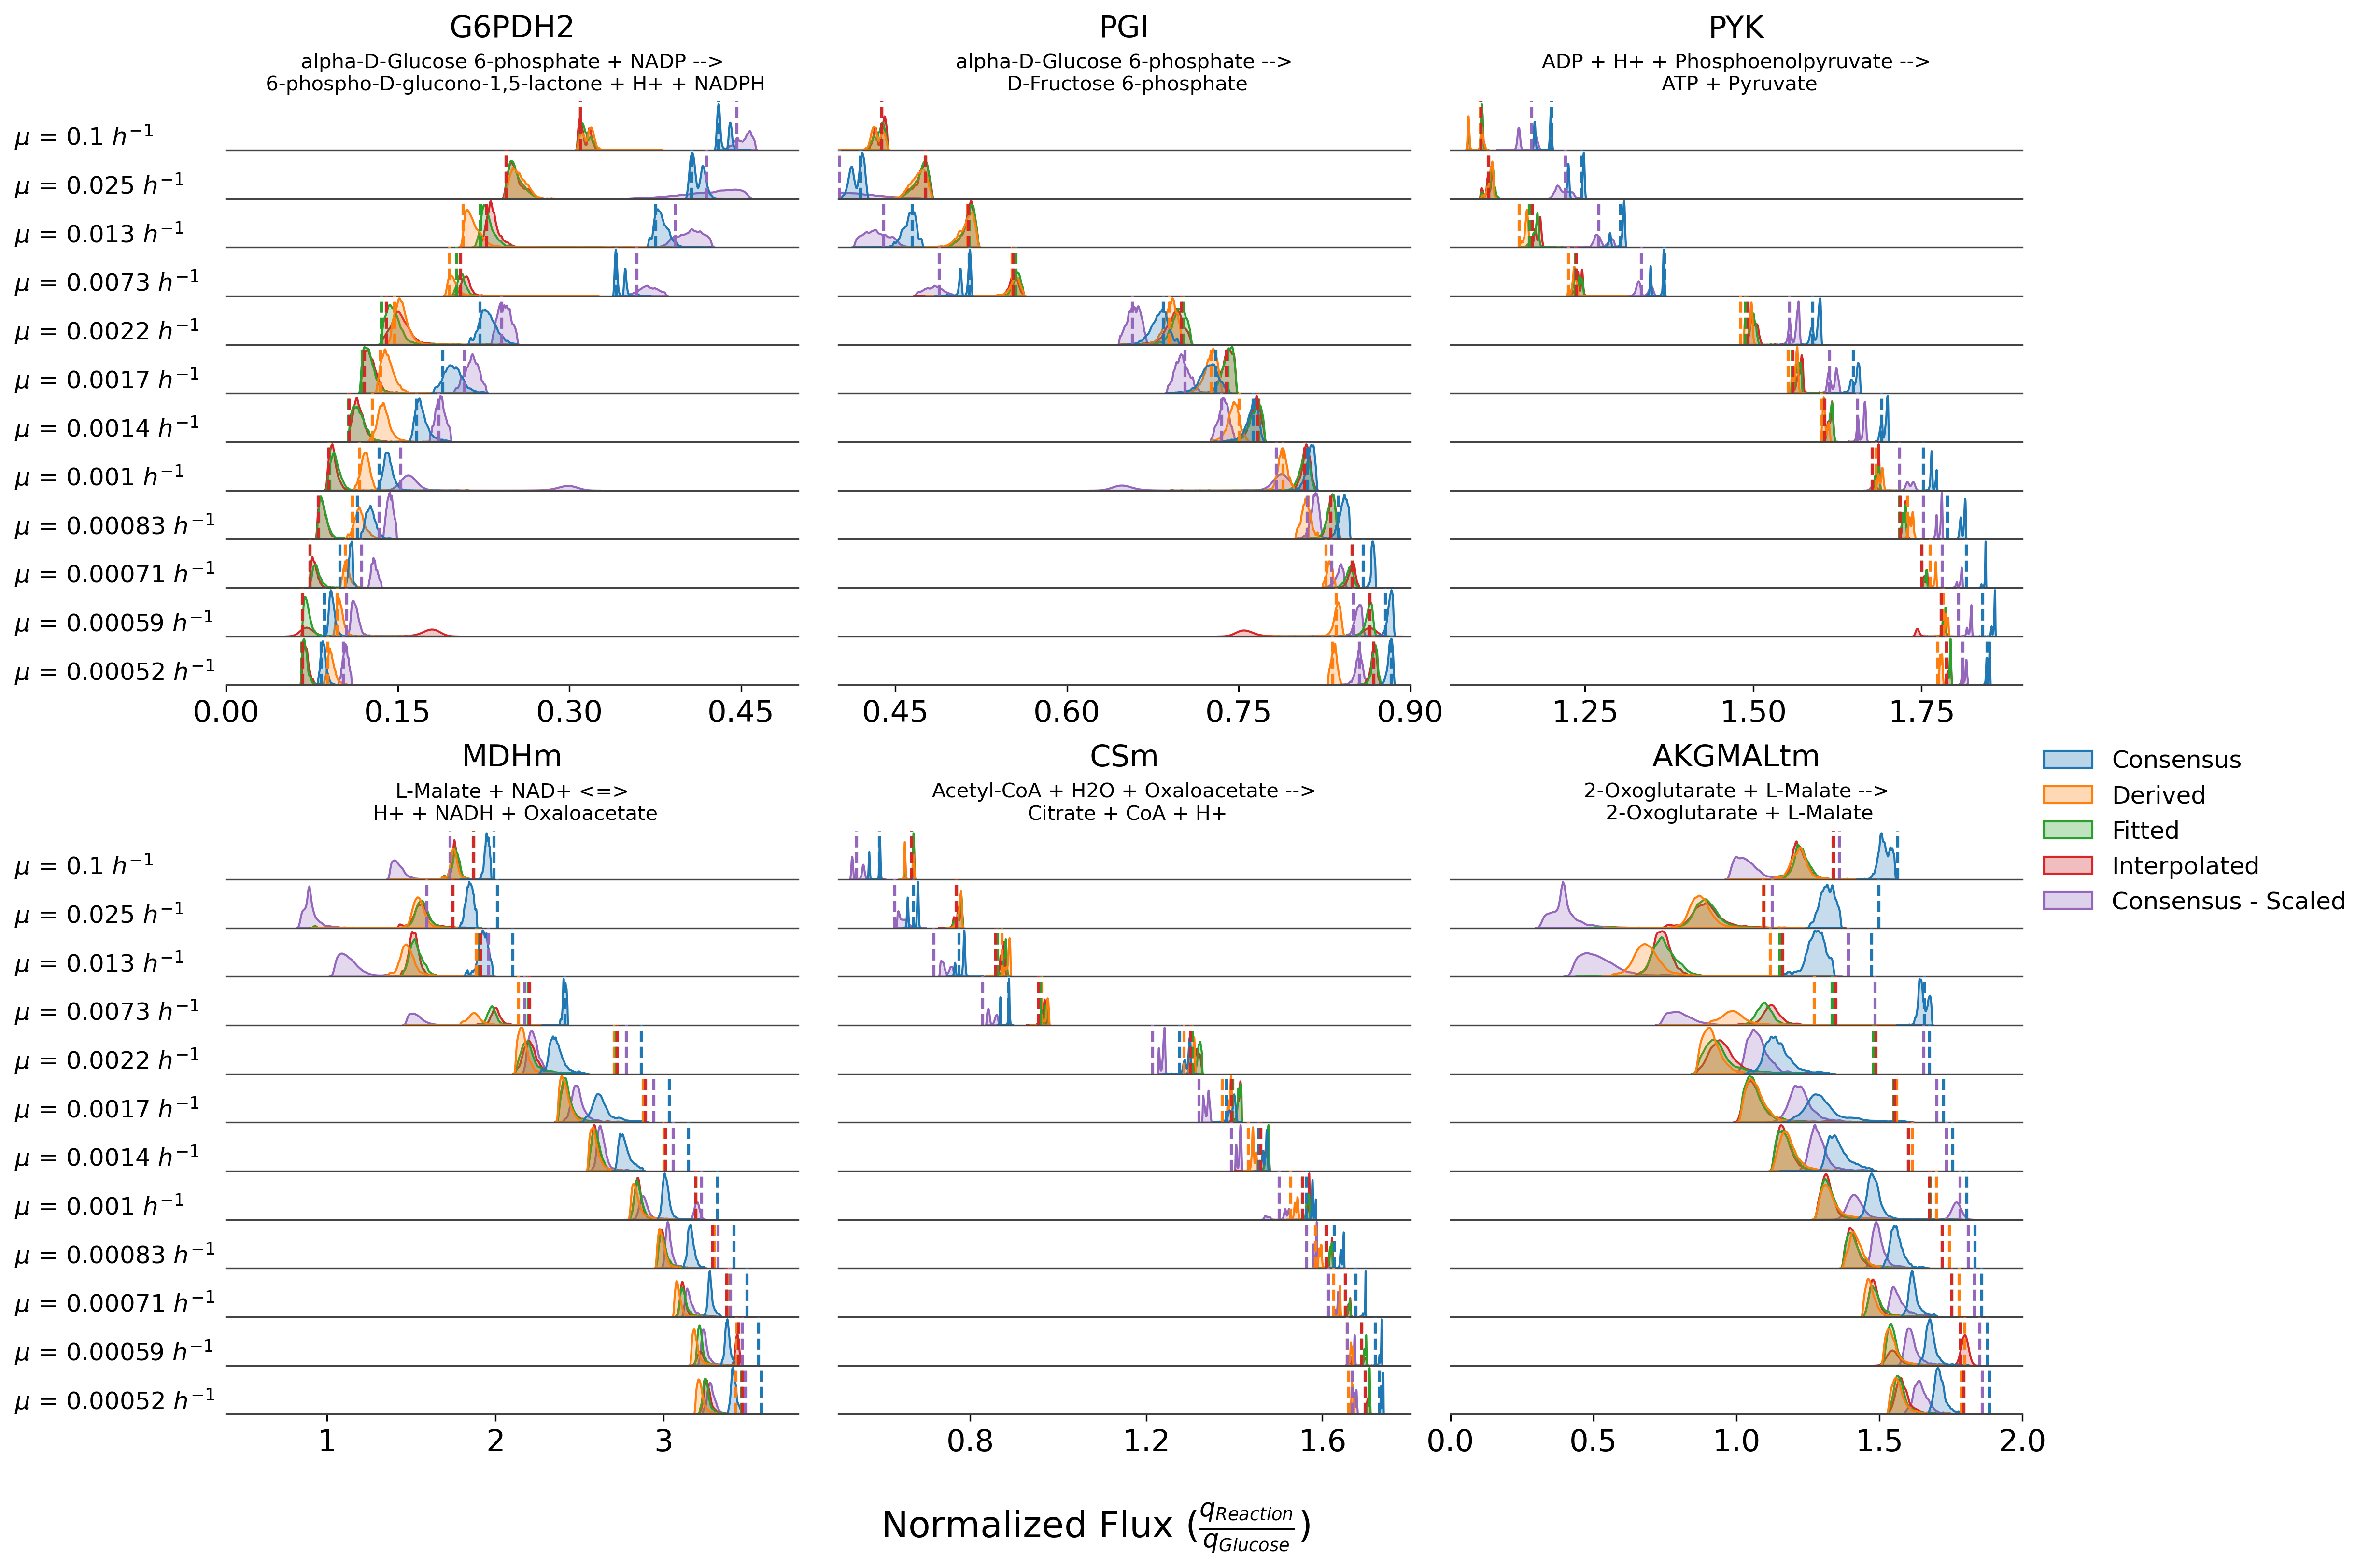

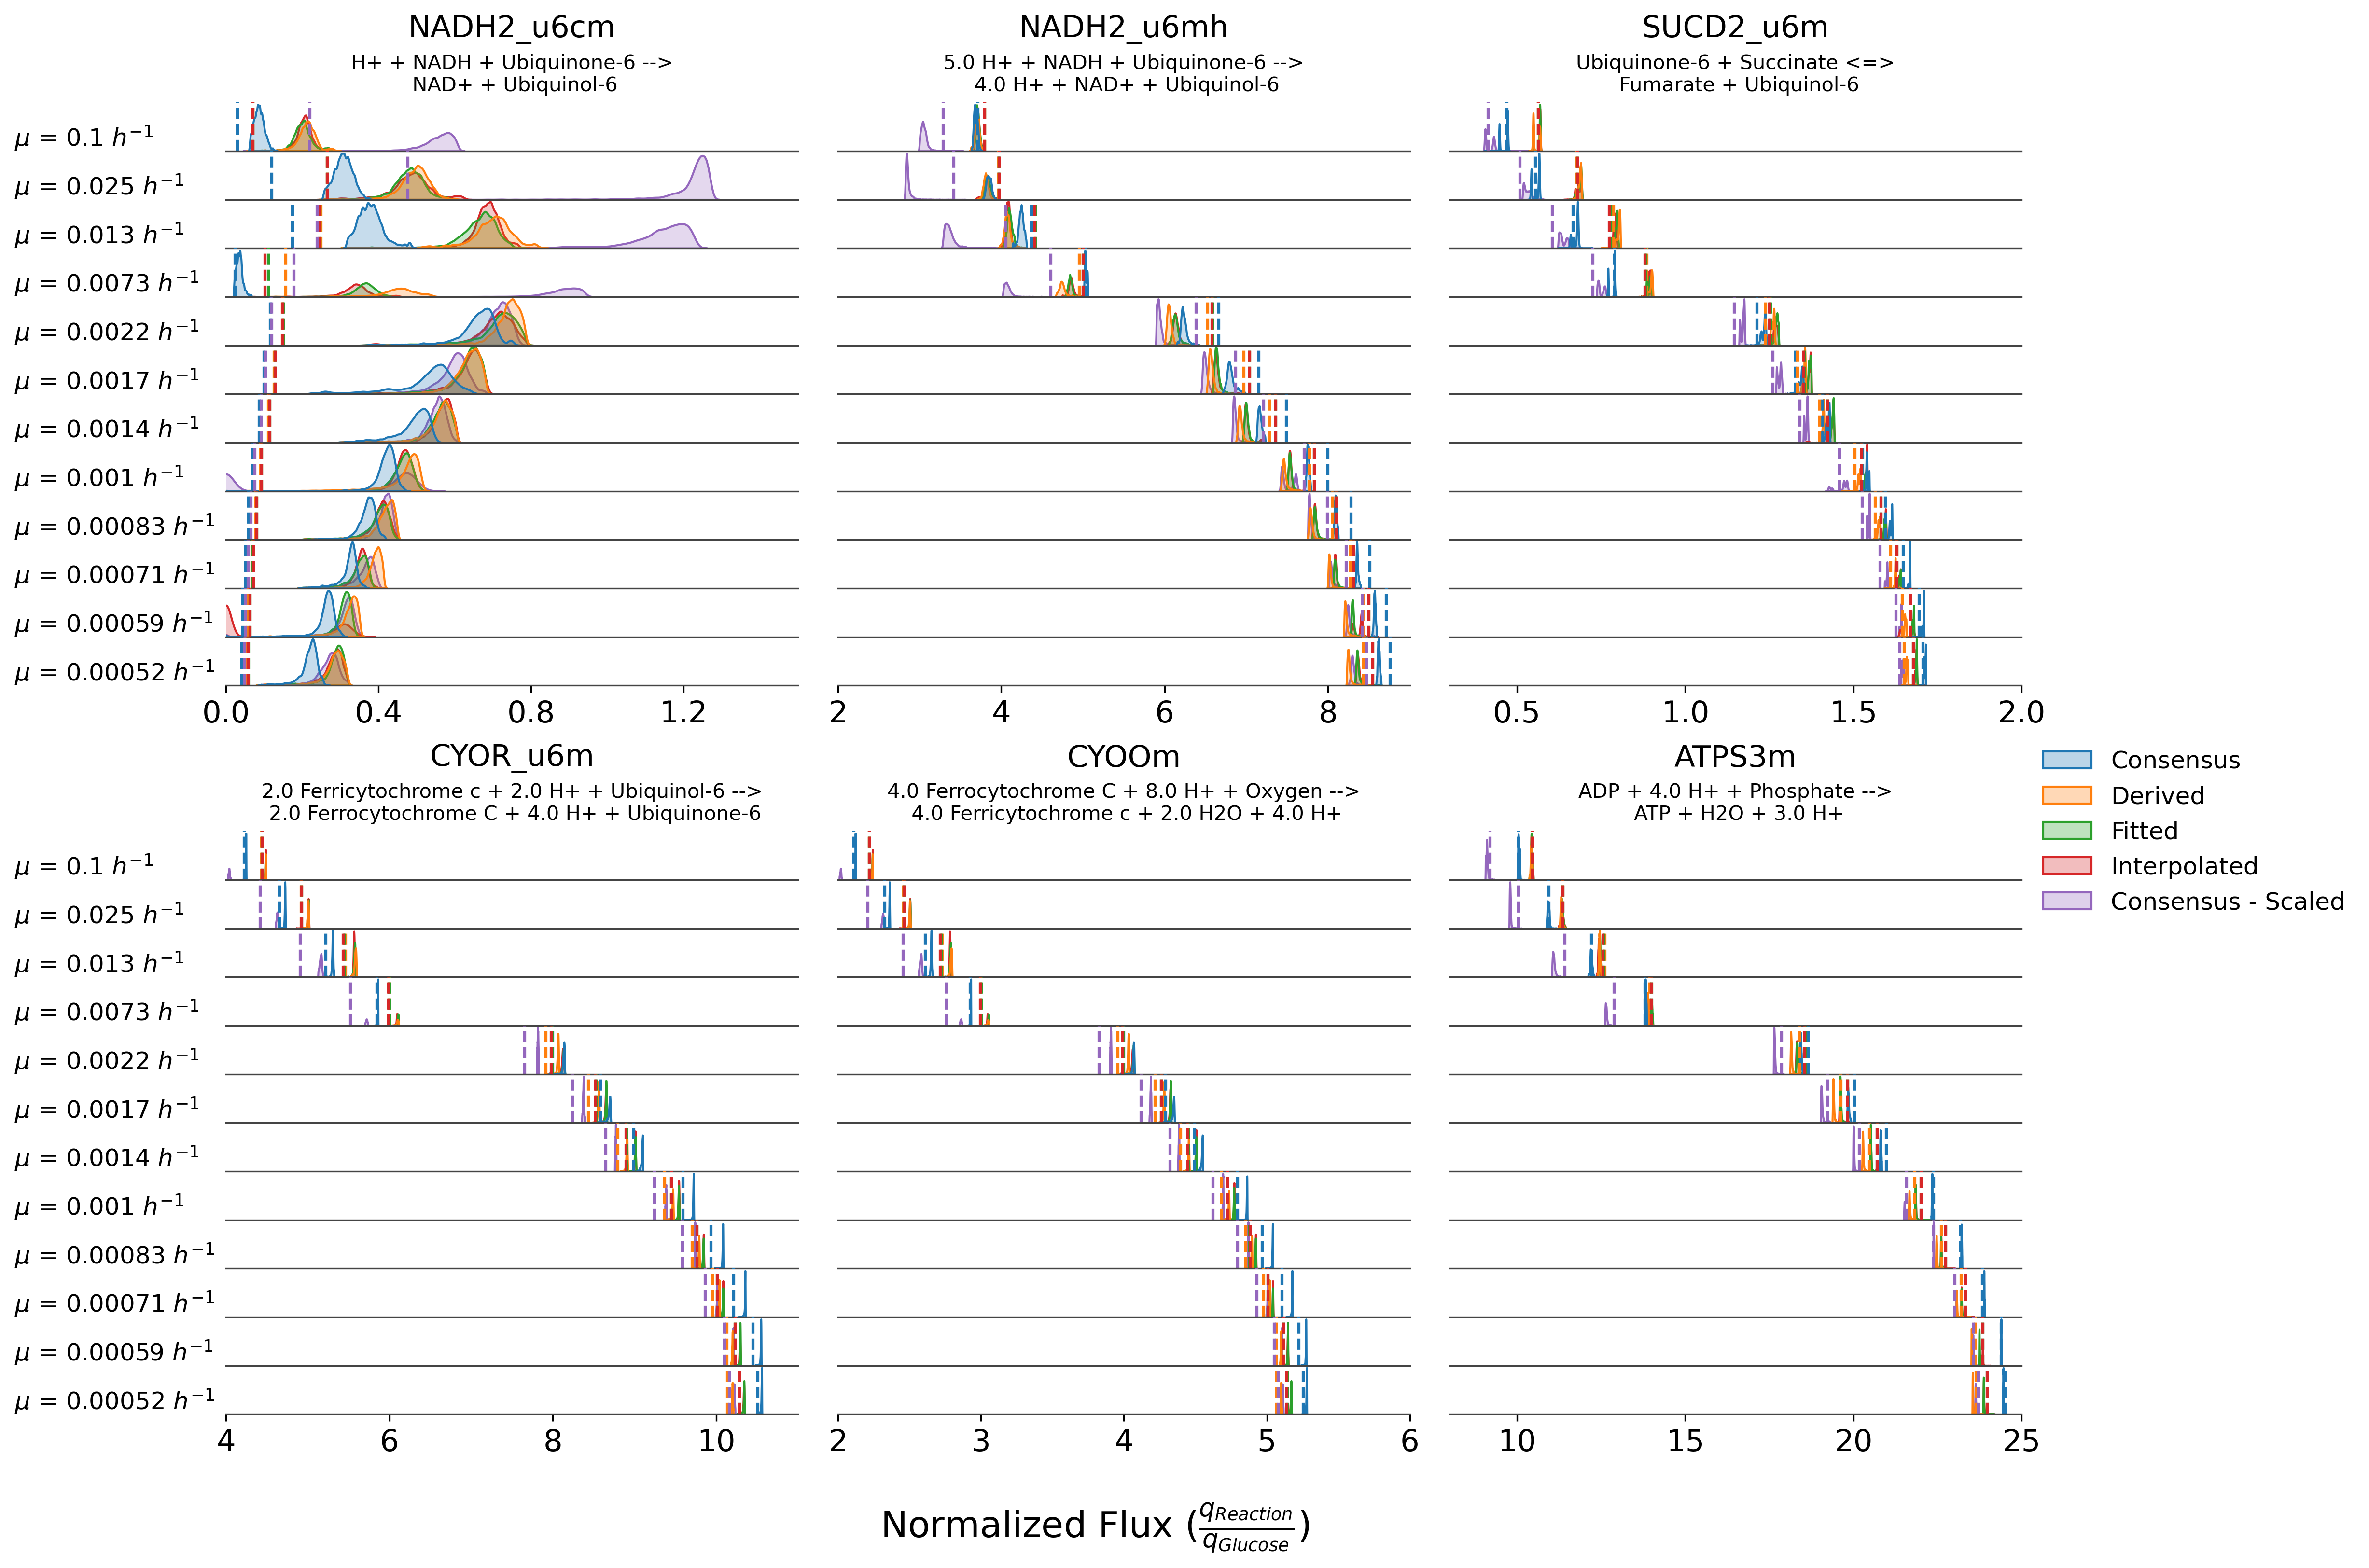

In [14]:
equation_names = ["Consensus","Derived", "Fitted", "Interpolated","ScaledConsensus"]

interesting_reactions = [("G6PDH2",0,0.5), ("PGI",0.4,0.9),("PYK",1.05,1.9),
                         ("MDHm", 0.4,3.8),("CSm", 0.5,1.8), ("AKGMALtm",0,2)]

plot_6_ridge(norm_chains_df, norm_pfba, interesting_reactions,"Gly&PPP", equation_names, model)

interesting_reactions = [("NADH2_u6cm",0,1.5),("NADH2_u6mh",2,9),("SUCD2_u6m",0.3,2),
                         ("CYOR_u6m", 4,11),("CYOOm", 2,6),("ATPS3m", 8,25)]

plot_6_ridge(norm_chains_df, norm_pfba, interesting_reactions,"ETC",equation_names, model)


##### Plot cofactor production fluxes

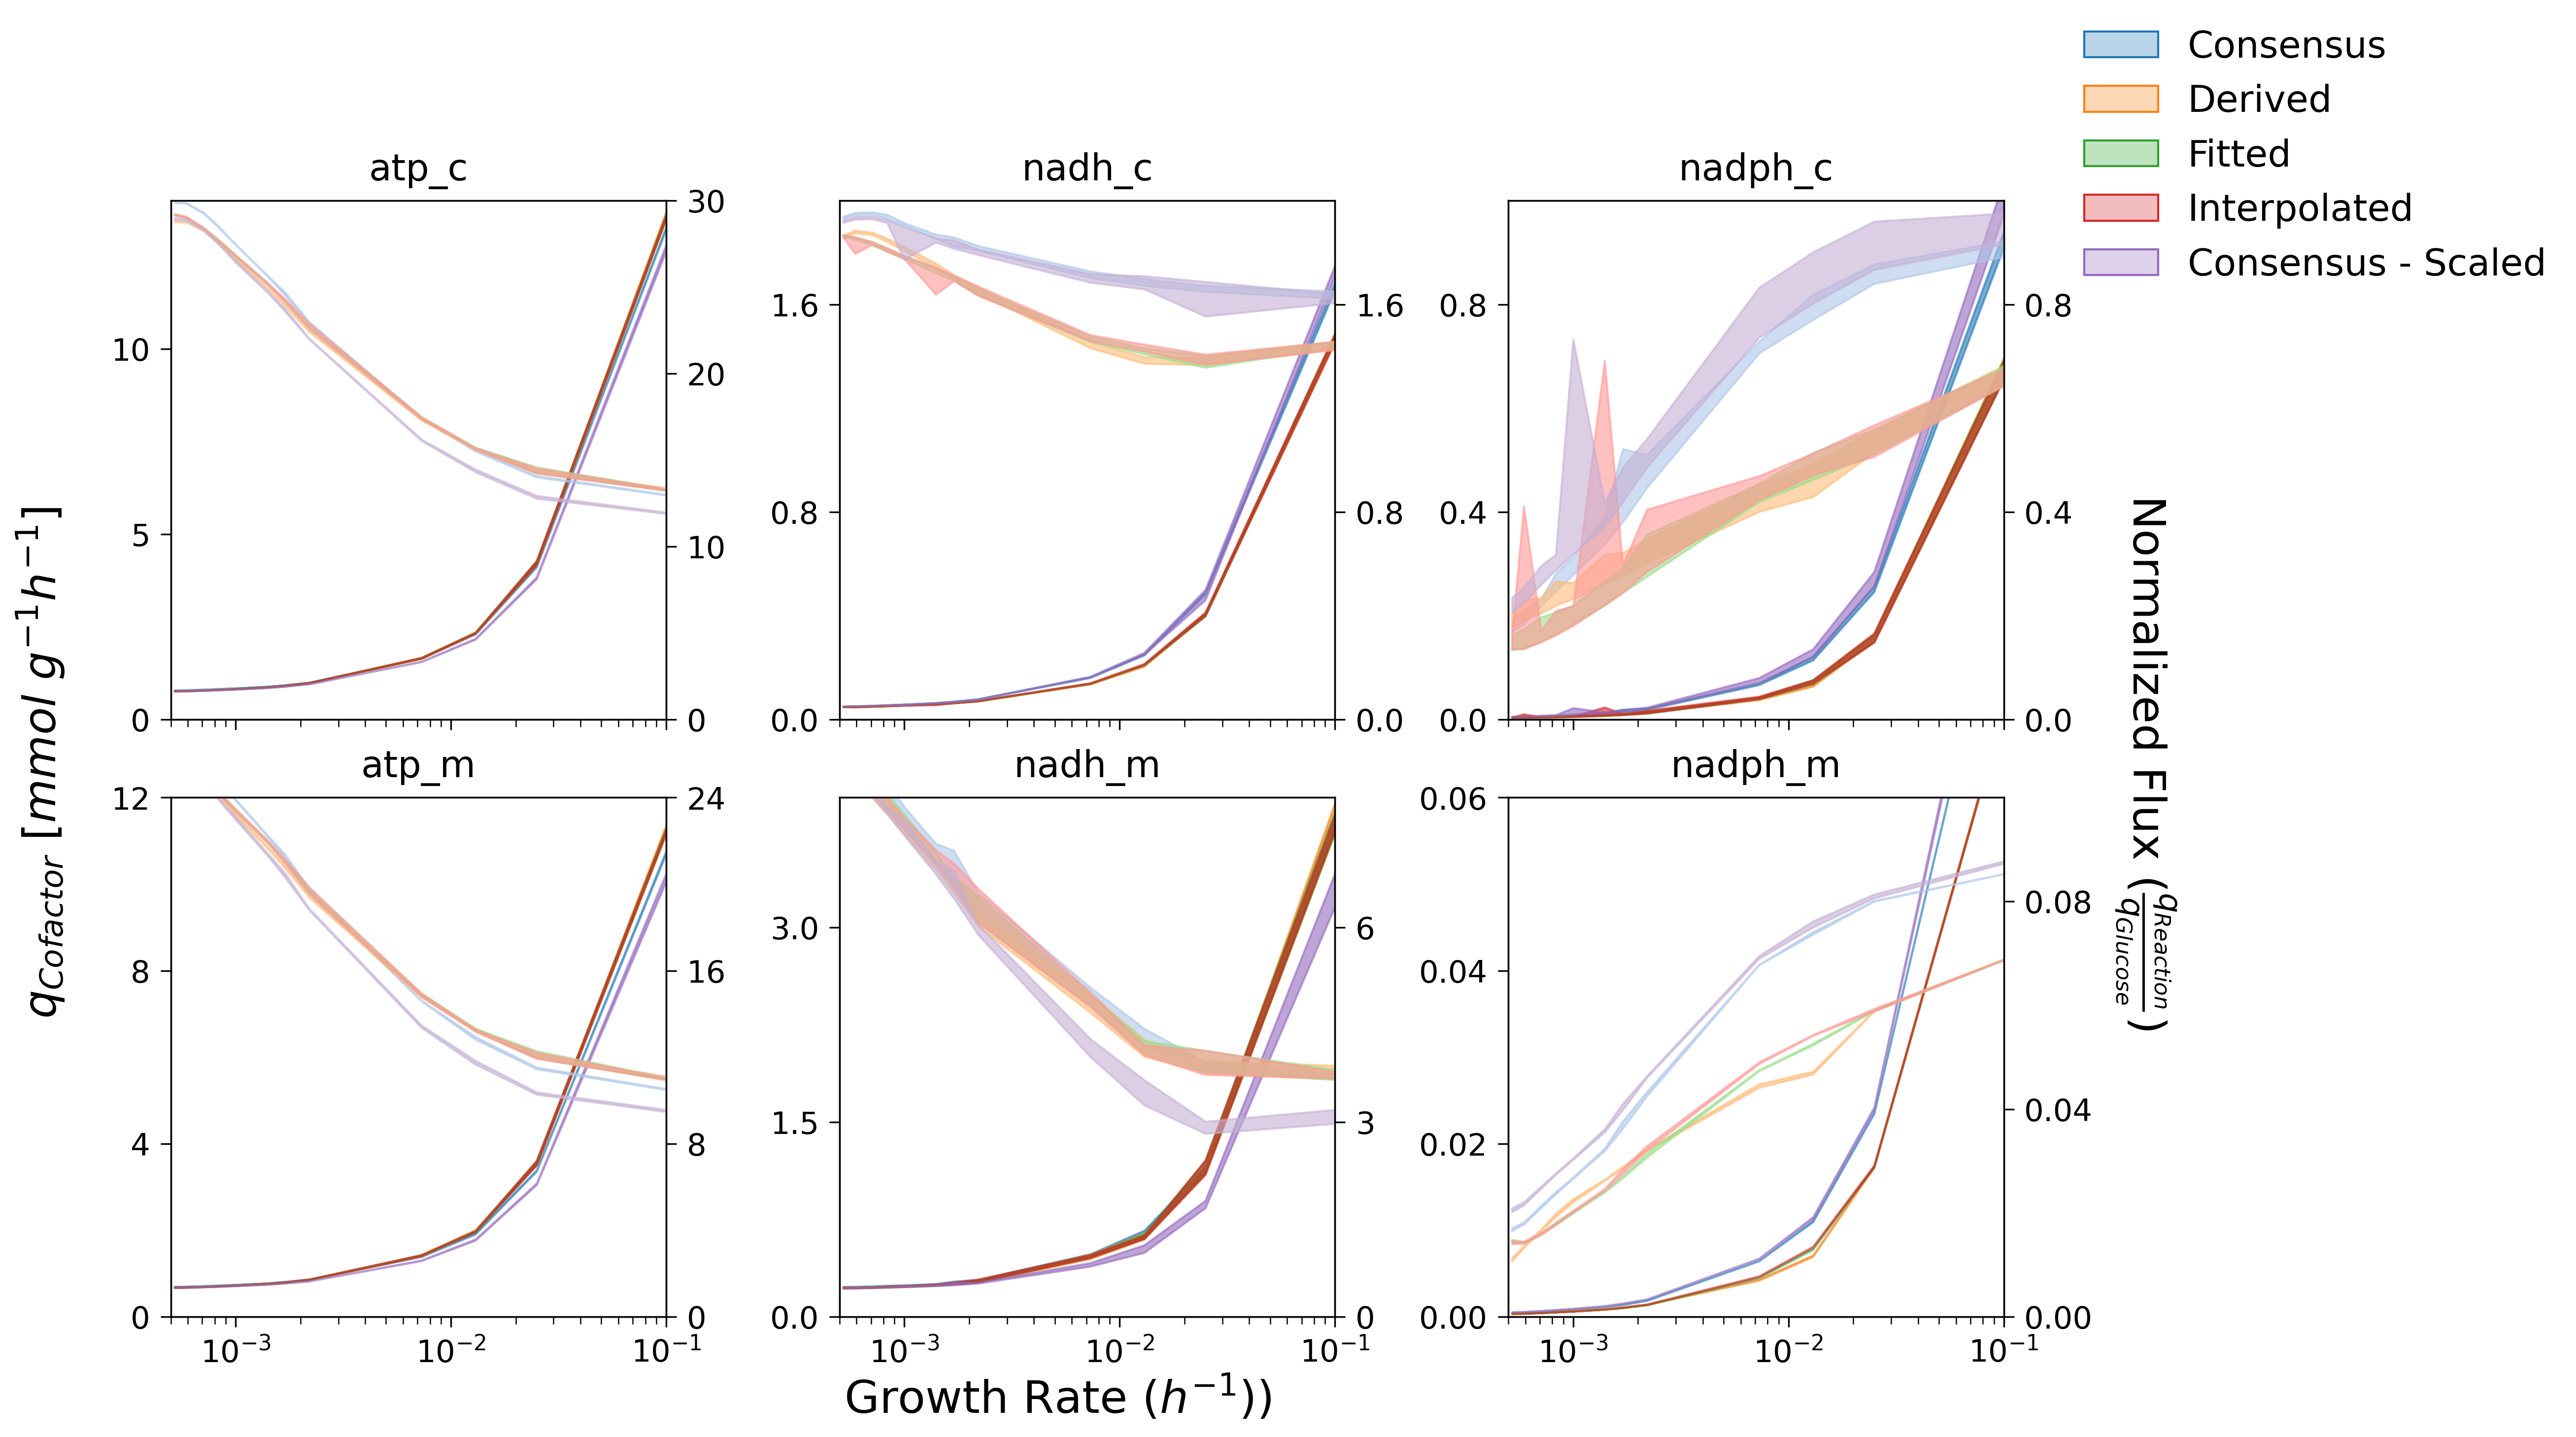

In [15]:
equation_names =  ["Consensus","Derived", "Fitted", "Interpolated","ScaledConsensus"]

interested_cofactors = [('atp_c',(0,14),(0,30)), 
                        ('nadh_c',(0,2),(0,2)), 
                        ('nadph_c', (0,1),(0,1)), 
                        ('atp_m', (0,12),(0,24)),
                        ('nadh_m', (0,4),(0,8)), 
                        ('nadph_m', (0,0.06),(0,0.1))]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,10),dpi=300, sharex="col") # ) # 

cmap = plt.cm.get_cmap('tab20', 20)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

for i, (cof, ax_lims, ax2_lims) in enumerate(interested_cofactors):
    norm_slice = cofactors_norm_ranges.loc[cof]
    total_slice = cofactors_ranges.loc[cof]

    if i > 2:
        ax = axs[1,i-3]
    else:
        ax = axs[0,i]
    
    ax.set_xscale("log")
    ax2 = ax.twinx()
    
    for j, biomass in enumerate(equation_names):
        
        x = total_slice.columns.astype(float)
        uy = total_slice.loc[(biomass, 0.975),:]  # 0.9875),:] 
        ly = total_slice.loc[(biomass, 0.025),:]  #0.0125),:] 
        
        ax.fill_between(x, uy, ly,alpha=0.6, color=color_list[j*2], label=biomass, zorder=10)

        uy = norm_slice.loc[(biomass, 0.975),:]  # 0.9875),:] 
        ly = norm_slice.loc[(biomass, 0.025),:] # 0.0125),:] 
        ax2.fill_between(x, uy, ly,alpha=0.6, color=color_list[1+j*2], label=biomass)
    
    ax.set_ylabel("")
    ax2.set_ylabel("")

    ax.set_xlabel("", fontsize=40, labelpad=20)
    ax.tick_params(labelsize=15, pad=5, length=5)
    ax.tick_params(which="minor",length=3.5)
    ax2.tick_params(labelsize=15, pad=5, length=5)
    ax.set_title(cof, fontsize=18,pad=10)
    ax.yaxis.set_major_locator(MaxNLocator(3))
    ax2.yaxis.set_major_locator(MaxNLocator(3))

   
    ax.set_xlim(0.0005,0.1)
    ax.set_ylim(ax_lims)
    ax2.set_ylim(ax2_lims)
    
plt.subplots_adjust(wspace=0.35, hspace=0.15) #hspace=0.25)


labels = [eqn if not eqn == "ScaledConsensus" else "Consensus - Scaled" for eqn in equation_names]       
legend_elements = [mpatches.Patch(edgecolor=cmap(i*2), label=eqn, facecolor=cmap(i*2)[:-1] + (0.3,)) for i, eqn in enumerate(labels)]
legend = fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.92,0.91), fontsize=18, frameon=False)

fig.text(0.07, 0.5, r'$q_{Cofactor}$ $[mmol\ g^{{-1}} h^{{-1}}]$', ha='center', va='center', fontsize=22,rotation=90)
fig.text(0.96, 0.5, r'Normalized Flux ($\frac{q_{Reaction}}{q_{Glucose}}$)', ha='center', va='center', fontsize=22,rotation=270)
fig.text(0.5, 0.07, r'Growth Rate ($h^{-1})$)', ha='center', va='center', fontsize=22)

fig.savefig(f"../results/plots/Mu_vs_Cofactors.png",
            bbox_inches='tight',transparent=True)

##### Plot gas exchanges 

KeyboardInterrupt: 

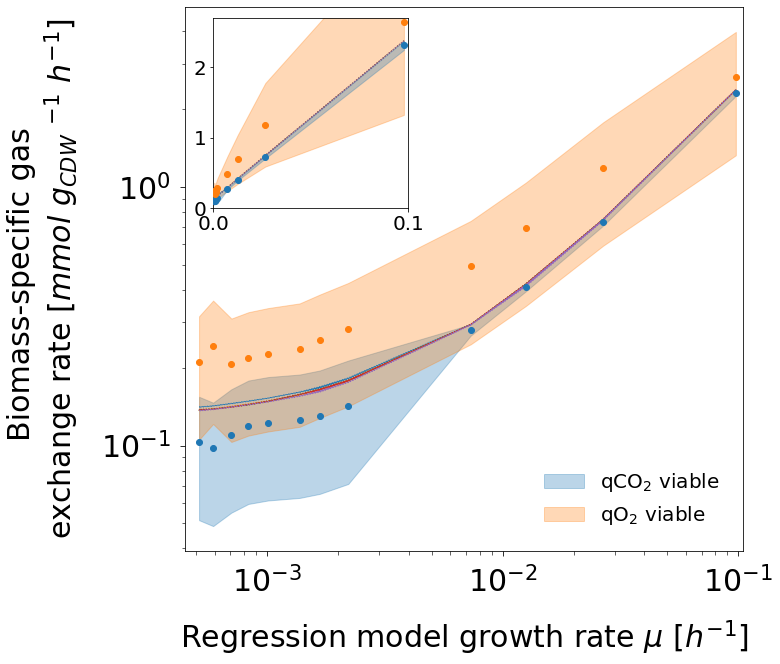

In [27]:
cmap = plt.cm.get_cmap('tab10', 10)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xscale("log")
ax.set_yscale("log")


x, y_co2, y_co2_sd, y_o2, y_o2_sd = DRinfo.loc[:, [("Growth Rate model 1/h", "mean"),
                                                    ("qCO2 viable model mmol/gh", "mean"),
                                                    ("qCO2 viable model mmol/gh", "std"),
                                                    ("qO2 viable model mmol/gh", "mean"),
                                                    ("qO2 viable model mmol/gh", "std")]].values.T
                    
      
ax.scatter(x,y_co2, c=color_list[0],zorder=10)
ax.fill_between(x, y_co2+y_co2_sd, y_co2-y_co2_sd, alpha=0.3, color=color_list[0], label="qCO$_2$ viable")

ax.scatter(x,y_o2, c=color_list[1],zorder=10)
ax.fill_between(x, y_o2+y_o2_sd, y_o2-y_o2_sd, alpha=0.3, color=color_list[1], label="qO$_2$ viable")      

ax.set_xlim(4.5e-4,0.105)

ax.set_xlabel('Regression model growth rate $\mu\ [h^{-1}]$', fontsize=30, labelpad=20)
ax.set_ylabel('Biomass-specific gas \nexchange rate $[mmol\ g_{CDW}\ ^{-1}\ h^{-1}$]', fontsize=30,labelpad=20)
ax.tick_params(labelsize=30, pad=10, length=5)
ax.tick_params(which="minor",length=3.5)

axins = ax.inset_axes([0.05, 0.63, 0.35, 0.35])

axins.scatter(x,y_co2, c=color_list[0],zorder=10)
axins.fill_between(x, y_co2+y_co2_sd, y_co2-y_co2_sd, alpha=0.3, zorder=10, color=color_list[0])

axins.scatter(x,y_o2,  c=color_list[1],zorder=10)
axins.fill_between(x, y_o2+y_o2_sd, y_o2-y_o2_sd, alpha=0.3, zorder=0, color=color_list[1])

for i, rxn in enumerate(["Ex_co2"]):
    
        
    for j, bio in enumerate(equation_names):

        col = color_list[i+j]
        
        ranges = quants.loc[bio].sort_index(level=1,ascending=False).abs()
        
        ax.fill_between(x,
                        ranges.loc[:,(rxn, 0.025) ],
                        ranges.loc[:,(rxn, 0.975) ],
                        alpha=1, zorder=5, color=col, linestyle=":",edgecolors=col)
    
        axins.fill_between(x,
                        ranges.loc[:,(rxn, 0.025) ],
                        ranges.loc[:,(rxn, 0.975) ],
                        alpha=0.6, zorder=5, color=col, linestyle=":",edgecolors=col)

axins.set_xlim([0,0.1])
axins.set_ylim([0,2.7])
axins.xaxis.set_major_locator(MultipleLocator(0.1))
axins.yaxis.set_major_locator(MultipleLocator(1))

axins.tick_params(labelsize=20)


# if log:
ax.legend(loc='lower right',bbox_to_anchor=(0.99,0.01), frameon=False, 
      fontsize='small',prop={'size':20})


fig.savefig(f"../results/plots/Mu_vs_Gas_sampled.png",
        bbox_inches='tight',transparent=True)

#### Statistical comparisons 
- significant differences between biomass equation generation methods & at different growth rates
Use 1000 samples instead of the 5000 to reduce computational time

In [17]:
%%time

all_sp_stats_norm = pd.DataFrame()

data = DRinfo.loc[:,model_viab_cols]

comparisons = [("Consensus","Derived"), ("Consensus", "Interpolated"), 
               ("Consensus", "Fitted"),
               ("Interpolated", "Derived"), ("Interpolated", "Fitted"),
               ("Derived", "Fitted")]


for comp in comparisons:

    first, second = comp
    
    comp_stats = []

    for name, values in data.iterrows():
        
        start = time.time()

        name = str(name)
        mu = values[0]
        df1 = pd.read_pickle(f"../results/sampling/{first}_{name}_T{optthin}.pkl.gz")
        df2 = pd.read_pickle(f"../results/sampling/{second}_{name}_T{optthin}.pkl.gz")

    
        shared_columns = list(set(df1.columns).intersection(df2.columns))
        df1 = df1.loc[:,shared_columns] 
        df2 = df2.loc[:,shared_columns] 

        mask = (df1.sum(axis=0) == 0)&(df1.sum(axis=0) == df2.sum(axis=0))
        
        df1 = df1.loc[:, ~mask]
        df2 = df2.loc[:, ~mask]
        
        df1 = df1.sample(1000)
        df2 = df2.sample(1000)

        rxn_names = df1.columns
        n_rxns = len(rxn_names) ### CHeck both have same number each time
        yield_rxn = 'Ex_glc_D'

        ix = df1.columns.get_loc(yield_rxn)
        
        df1 = df1.values
        df2 = df2.values
        

        rel_df1 = df1 * np.abs(1/df1[:,[ix]])
        rel_df2 = df2 * np.abs(1/df2[:,[ix]])

        index = pd.MultiIndex.from_product([[name], rxn_names])
        sp_stats = pd.DataFrame(columns = ['Reaction','U-val', 'M P-value', 'RBC', 'CLES', 'Rhat', 'VD-A', 'VD Magnitude',"Cliff's D"])

        for_pool = []
        for i in np.arange(0,n_rxns):
            rxn_name = rxn_names[i]
            col_df1 = rel_df1[:,i]
            col_df2 = rel_df2[:,i]
            for_pool.append([col_df1, col_df2, rxn_name])
        

        pool = Pool(processes=processes)
        all_series = pool.starmap(calcstats, for_pool)
        pool.close()
        
        sp_stats = pd.concat(all_series,axis=1).T
        
        reject, adj_p, alpha_sid, alpha_bon = multipletests(np.abs(sp_stats["M P-value"].values), method="bonferroni",alpha=0.05/2) ## two tailed, so divide by 2
        sp_stats["Reject"] = reject
        sp_stats["Adjusted-p"] = adj_p.astype(float)
        sp_stats["M P-value"] = sp_stats["M P-value"].astype(float)
        sp_stats["Sampling Point"] = name
        
        comp_stats.append(sp_stats)
    comp_df = pd.concat(comp_stats)
    comp_df["Comparisons"] = f"{first} vs {second}"
    comp_df.set_index(["Comparisons", "Sampling Point","Reaction"], inplace=True)
        
        
    all_sp_stats_norm = all_sp_stats_norm.append(comp_df)
all_sp_stats_norm["Reaction Number"] = all_sp_stats_norm.groupby("Sampling Point").cumcount() + 1   
all_sp_stats_norm["Abs Cliff's D"] = all_sp_stats_norm["Cliff's D"].abs()
all_sp_stats_norm["Rxn Subsystem"] = all_sp_stats_norm.index.get_level_values("Reaction").to_series().apply(lambda x: rgdict.get(x)).values
all_sp_stats_norm.to_csv(f"../results/dataframes/FluxYield_Statistics.csv")

CPU times: user 1min 20s, sys: 2min 14s, total: 3min 35s
Wall time: 3min 46s


Median percentage of reactions differing across all comparisons

In [18]:
rejects = all_sp_stats_norm.groupby(["Comparisons", "Sampling Point"])["Reject"].sum()#["Reject"]
total_group = all_sp_stats_norm.groupby(["Comparisons", "Sampling Point"]).count().values[:,0]
rejects = (rejects/total_group).to_frame().unstack()
rejects.stack().median()

Reject    0.690845
dtype: float64

- Percentage of reactions that had a large effect size in a comparison
Note, that between 5% and 10% of reactions had a large effect size for the C0.1 and 0.0 sampling points for the Derived, Fitted and Inteprolated despite the fact the biomass equation is the same. This is largely due to random smapling effecs

In [19]:
large = (all_sp_stats_norm["VD Magnitude"] == "large").groupby(["Comparisons", "Sampling Point"]).sum()
large = (large/total_group).to_frame().unstack()
large

VD Magnitude                                \
Sampling Point                     0.0       0.9       1.9      13.9   
Comparisons                                                            
Consensus vs Derived          0.584098  0.518173  0.483700  0.476603   
Consensus vs Fitted           0.564436  0.511090  0.513339  0.479464   
Consensus vs Interpolated     0.550739  0.504771  0.479037  0.460664   
Derived vs Fitted             0.119522  0.411656  0.439114  0.424088   
Interpolated vs Derived       0.152174  0.451434  0.422904  0.429319   
Interpolated vs Fitted        0.063168  0.409004  0.400742  0.325843   

                                                                             \
Sampling Point                 16.9      19.9      23.9      27.9       5.9   
Comparisons                                                                   
Consensus vs Derived       0.393965  0.427144  0.434243  0.422738  0.492780   
Consensus vs Fitted        0.394803  0.451973  0.436552  0.425703  0.473917   
Consensus vs Interpolated  0.408163  0.454624  0.418167  0.451744  0.480508   
Derived vs Fitted          0.412564  0.432140  0.434500  0.448136  0.442727   
Interpolated vs Derived    0.431020  0.427731  0.426050  0.467649  0.425373   
Interpolated vs Fitted     0.230051  0.254237  0.283971  0.293367  0.359161   

                                                         
Sampling Point                  7.9       9.9      C0.1  
Comparisons                                              
Consensus vs Derived       0.484248  0.486854  0.540984  
Consensus vs Fitted        0.509892  0.444543  0.588652  
Consensus vs Interpolated  0.522870  0.439965  0.570401  
Derived vs Fitted          0.459411  0.472680  0.105005  
Interpolated vs Derived    0.391808  0.450388  0.082587  
Interpolated vs Fitted     0.374217  0.289991  0.078201

In [20]:
large.stack().median()

VD Magnitude    0.435526
dtype: float64

##### Enrichment analysis on the different subsystems to determine where the significant changes occured

In [21]:
rgdict = {}
for g in model.groups:
    for r in g.members:
        rgdict[r.id] = g.id.title()
        
subsystem_df = pd.DataFrame.from_dict(rgdict, orient="index").reset_index()
subsystem_df = subsystem_df.rename(columns={"index":"Rxn", 0:"Subsystem"})



In [22]:
all_output = []


for comparison in large.index:
    for sp in large.columns.get_level_values(1):
        
        ## using enrich function in CBModellingFuncs
        temp = all_sp_stats_norm.loc[(comparison, sp),"VD Magnitude"]
        output = enrich(temp[temp == "large"].index, subsystem_df["Rxn"].to_list(), subsystem_df) 
        if comparison == f"{first} vs {second}" and sp ==name:
            save = output
        all_output.extend(output.loc[output["adj_pval"] < 0.05, "Subsystem annotation"].to_list())
        
number_enriched = pd.Series(all_output).value_counts().to_frame().rename(columns={0:"Counts"})
number_enriched["Fraction"] = number_enriched["Counts"]/(large.shape[0]*large.shape[1])

/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [23]:
number_enriched

Counts  Fraction
Sphingolipid Metabolism                                 71  0.986111
Sterol Metabolism                                       66  0.916667
Quinone Biosynthesis                                    62  0.861111
Histidine Metabolism                                    62  0.861111
Transport, Er                                           58  0.805556
Pentose Phosphate Pathway                               55  0.763889
Porphyrin And Chlorophyll Metabolism                    53  0.736111
Fatty Acid Biosynthesis                                 48  0.666667
Riboflavin Metabolism                                   47  0.652778
Valine, Leucine, And Isoleucine Metabolism              47  0.652778
Citric Acid Cycle                                       41  0.569444
Pantothenate And Coa Biosynthesis                       40  0.555556
Folate Metabolism                                       35  0.486111
Glycolysis/Gluconeogenesis                              28  0.388889
Amino Sugar And Nucleotide Sugar Metabolism             22  0.305556
Thiamine Metabolism                                     19  0.263889
Methionine Metabolism                                   17  0.236111
Cysteine Metabolism                                     13  0.180556
Nucleotide Metabolism                                   12  0.166667
Glyoxylate And Dicarboxylate Metabolism                 12  0.166667
Arginine And Proline Metabolism                          9  0.125000
Other Amino Acid Metabolism                              8  0.111111
Nad Biosynthesis                                         8  0.111111
Pyridoxine Metabolism                                    7  0.097222
Transport, Golgi Apparatus                               6  0.083333
Transport, Mitochondrial                                 5  0.069444
Tyrosine, Tryptophan, And Phenylalanine Metabolism       5  0.069444
Vitamin And Cofactor Biosynthesis                        4  0.055556
Oxidative Phosphorylation                                4  0.055556
Methanol Metabolism                                      3  0.041667
Glycerolipid Metabolism                                  3  0.041667
Phospholipid Metabolism                                  2  0.027778
Alanine And Aspartate Metabolism                         2  0.027778
Threonine And Lysine Metabolism                          2  0.027778
Glycine And Serine Metabolism                            1  0.013889
Carbohydrate Metabolism                                  1  0.013889
Pyruvate Metabolism                                      1  0.013889

### Additional analysis
- Not included in manuscript

##### Alternative plot of the 12 reactions. Flux yields and flux vs growth rate

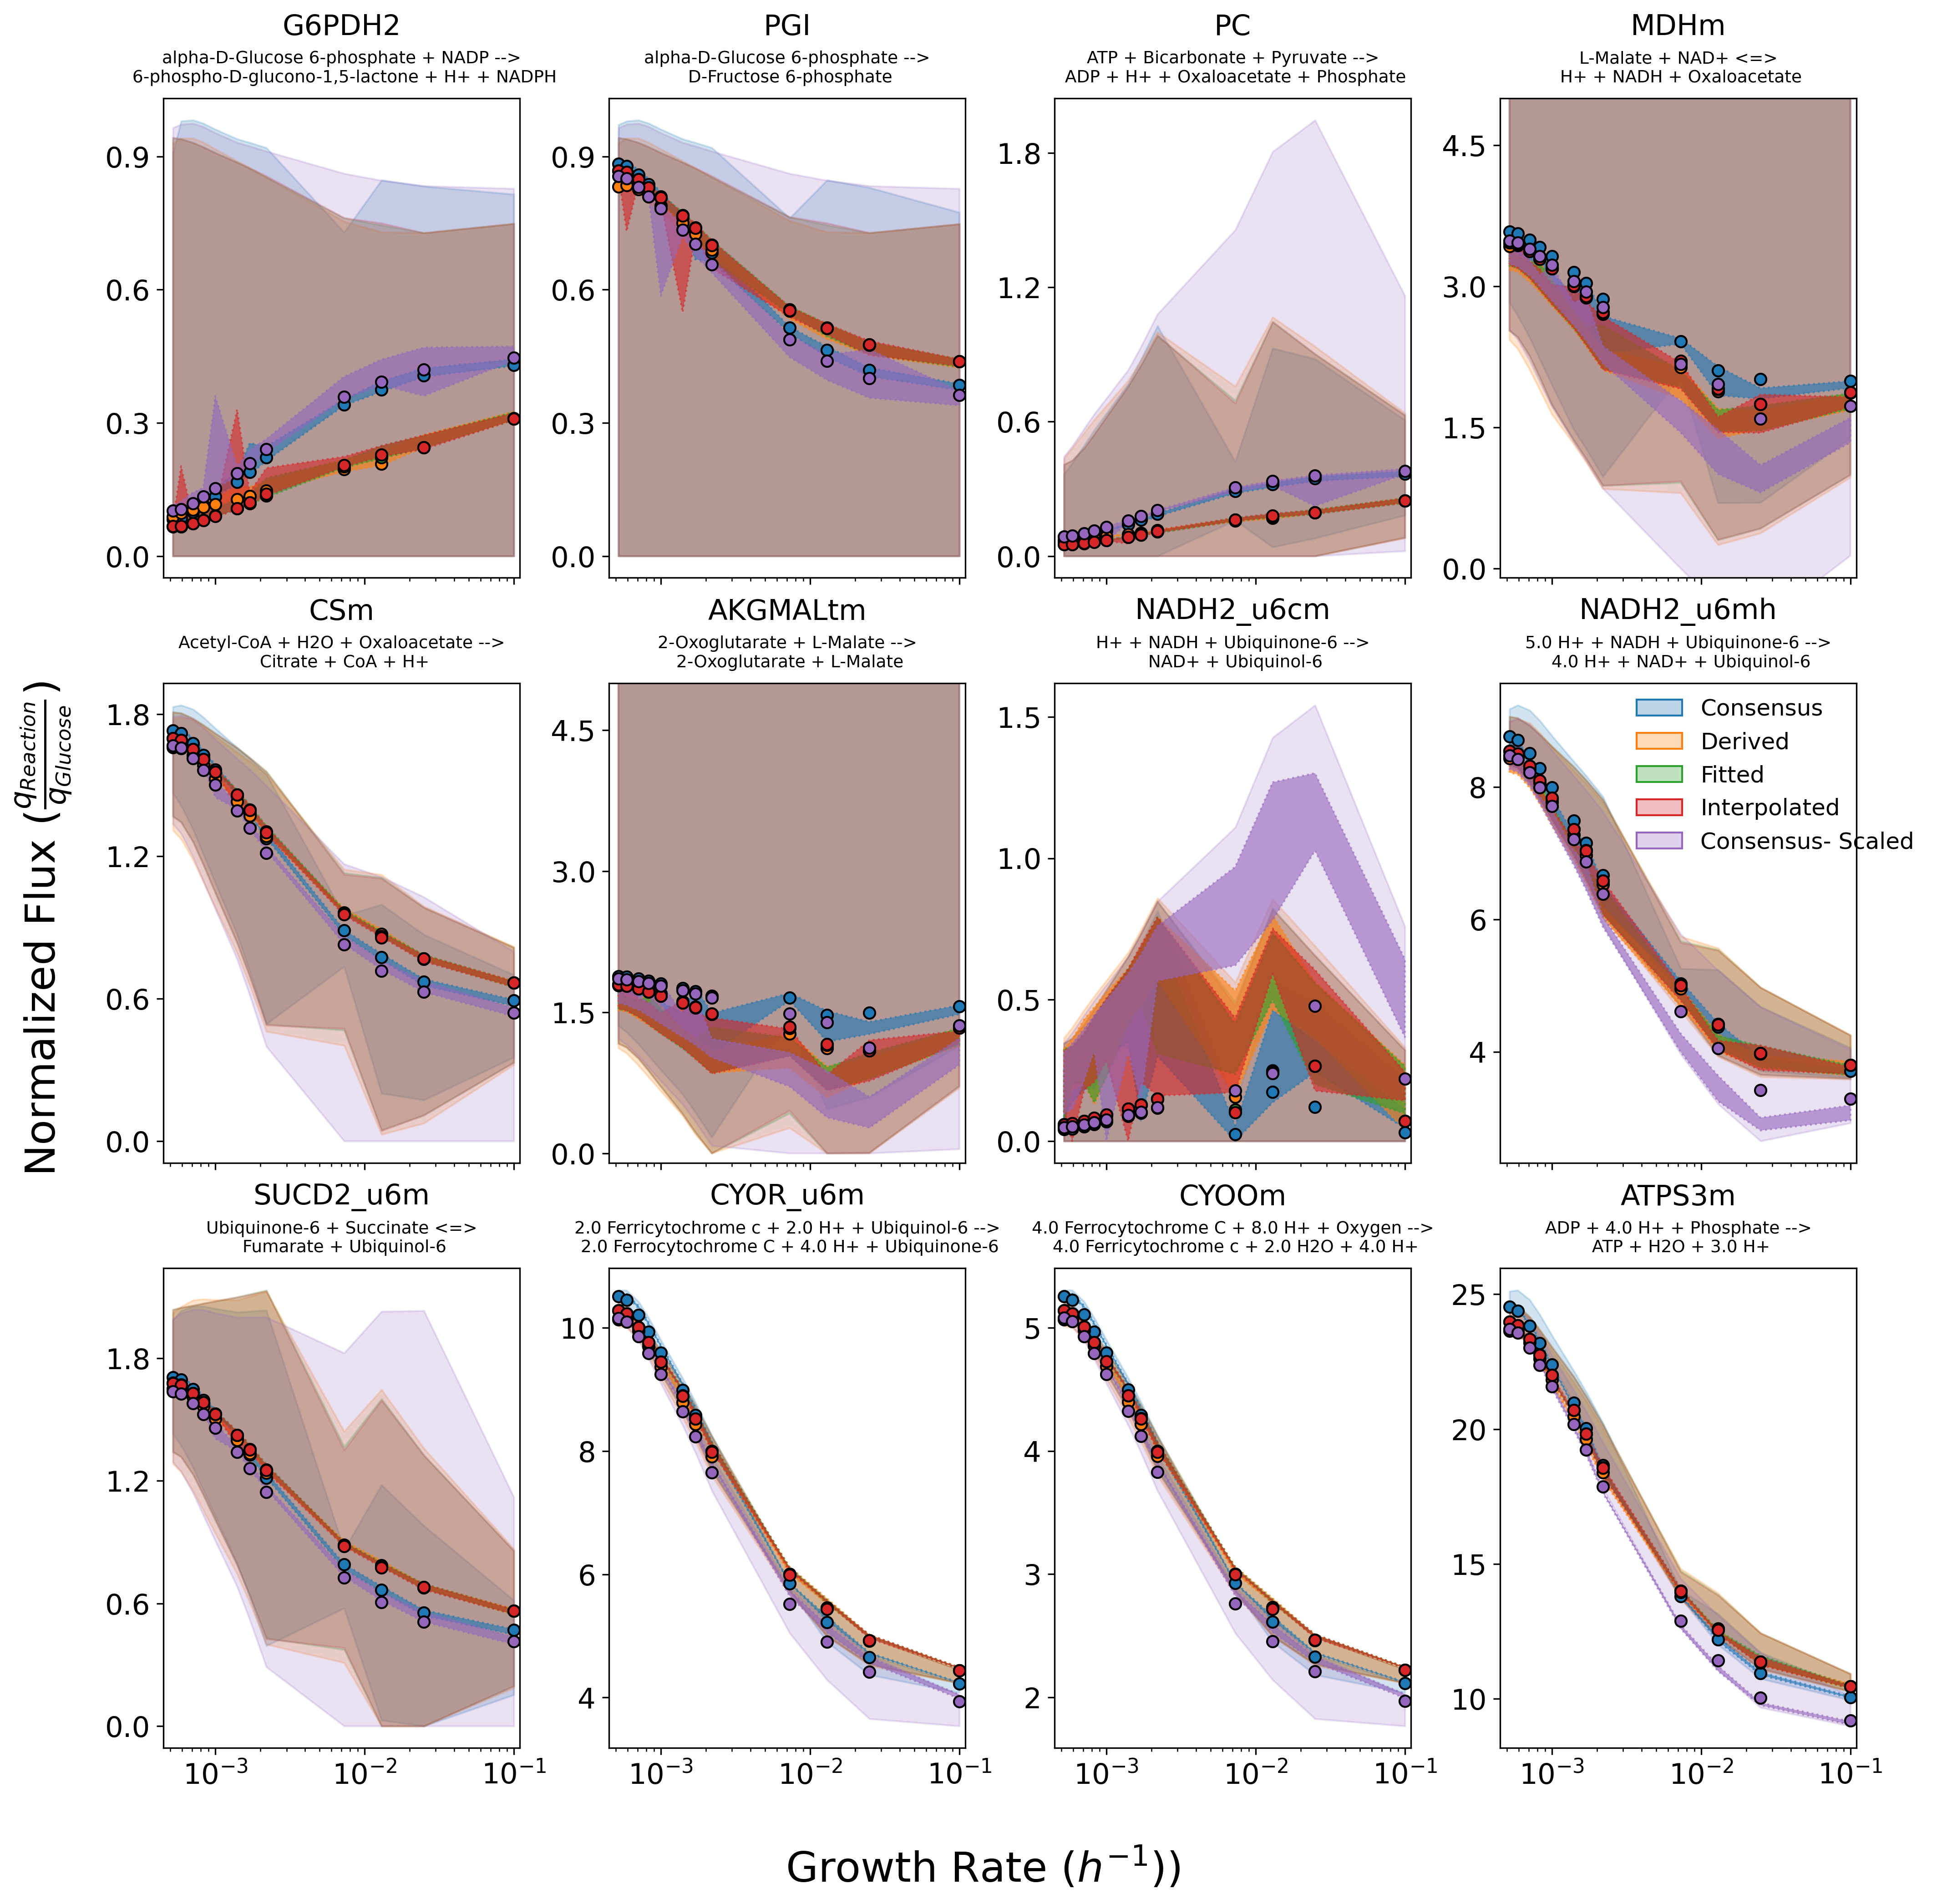

In [28]:
def plot_12_reactions(interesting_reactions,out_name,biomass_equations, quants, fva, pfba):
    
    number_sps = len(quants.index.get_level_values("Time").unique()) #norm_chains.Time.unique())

    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,16),dpi=300, sharex="col") # ) # 

    cmap = plt.cm.get_cmap('tab10', 10)
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

    for i, (rxn,lb,ub) in enumerate(interesting_reactions):

        if i < 4:
            ax = axs[0,i]
        elif i < 8:
            ax = axs[1,i-4]
        else:
            ax = axs[2,i-8]
            
        plotting_fluxes(ax, rxn, quants, fva, pfba,color_list=color_list,biomass=biomass_equations)
        ax.set_xscale("log")
        if rxn in ["AKGMALtm", "MDHm"]:
            ax.set_ylim(-0.1, 5)
        # ax.set_ylim(lb, ub)
        ax.set_xlim(4.5e-4,0.11)
        from matplotlib.ticker import MultipleLocator, MaxNLocator
        ax.yaxis.set_major_locator(MaxNLocator(4))

        string = model.reactions.get_by_id(rxn).build_reaction_string(True)
        if string.find(">") > -1:
            string = string.split(">")
            string = (">\n").join(string)
        elif string.rfind("-") > -1:
            string = string.rsplit("-",1)
            string = ("-\n").join(string)


        ax.set_xlabel("")
        ax.tick_params(labelsize= 15)

        ax.text(0.5, 1.12, rxn, fontsize=15, transform = ax.transAxes,horizontalalignment='center',verticalalignment='bottom') 
        ax.text(0.5, 1.1, string, fontsize=9, transform = ax.transAxes,horizontalalignment='center',verticalalignment='top')  
        

    import matplotlib.patches as mpatches
    plt.subplots_adjust(wspace=0.25, hspace=0.22) #hspace=0.25)


    legend_elements = [mpatches.Patch(edgecolor=cmap(k), label=eqn if not eqn == "ScaledConsensus" else "Consensus - Scaled", 
                                      facecolor=cmap(k)[:-1] + (0.3,)) for k, eqn in enumerate(biomass_equations)]
   
    legend = fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.79,0.57), fontsize=12, frameon=False)

    fig.text(0.07, 0.5, r'Normalized Flux ($\frac{q_{Reaction}}{q_{Glucose}}$)', ha='center', va='center', fontsize=22,rotation=90)
    fig.text(0.5, 0.07, r'Growth Rate ($h^{-1})$)', ha='center', va='center', fontsize=22)

    fig.savefig(f"../results/plots/FluxYieldAll.png",
            bbox_inches='tight',transparent=True)  
    
def plotting_fluxes(ax,rxn, sampling_data, fva_data, pfba_data, color_list=None, biomass=None):
    if biomass == None:
        biomass = ["Dynamic", "Consensus"]
    elif type(biomass) != list:
        biomass = list(biomass)
    
    if color_list == None:
        cmap = plt.cm.get_cmap('tab10', 10)
        color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    
    
    for i, bio in enumerate(biomass):
        
        col = color_list[i]
        
        fva_ranges = fva_data.loc[bio].sort_index(level=1)
        samples = sampling_data.loc[bio].sort_index(level=1)
        flux = pfba_data.loc[bio].sort_index(level=1)
        
        ax.fill_between(fva_ranges.index.get_level_values("Growth Rate").astype(float),
                        fva_ranges.loc[:,(rxn, "minimum") ],
                        fva_ranges.loc[:,(rxn, "maximum") ],
                        alpha=0.2,zorder=0, color=col)
        
        ax.fill_between(samples.index.get_level_values("Growth Rate").astype(float),
                        samples.loc[:,(rxn, 0.025) ],
                        samples.loc[:,(rxn, 0.975) ],
                        alpha=0.6, zorder=5, color=col, linestyle=":",edgecolors=col)
        
        ax.scatter(flux.loc[:,rxn].index.get_level_values("Growth Rate").astype(float),
                   flux.loc[:,rxn],zorder=10, color=col, edgecolors="black")


interesting_reactions = [("G6PDH2",0,0.5), ("PGI",0.4,0.9),("PC",0,1),
                         ("MDHm", 0.4,3.8),("CSm", 0.5,1.8), ("AKGMALtm",0,2),
                         ("NADH2_u6cm",0,1.5),("NADH2_u6mh",2,9),("SUCD2_u6m",0.3,2),
                         ("CYOR_u6m", 4,11),("CYOOm", 2,6),("ATPS3m", 8,25)] 


plot_12_reactions(interesting_reactions,"All",equation_names, norm_quants, norm_fva,norm_pfba)


##### RQ plot

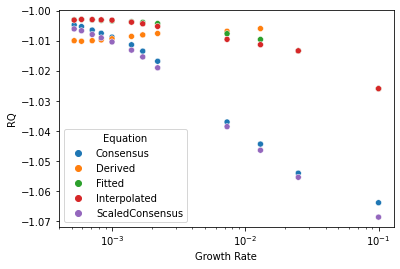

In [25]:
RQ = norm_chains_df["Ex_co2"].div(norm_chains_df["Ex_o2"])

fig, ax = plt.subplots()
to_plot = RQ.reset_index()
to_plot.rename(columns={0:"RQ"}, inplace=True)
to_plot = to_plot[to_plot["Equation"].isin(equation_names)]
to_plot["Growth Rate"] = to_plot["Growth Rate"].astype(float)
to_plot = to_plot.groupby(["Equation", "Growth Rate"]).median().reset_index()
sns.scatterplot(data=to_plot, x="Growth Rate",y="RQ",hue="Equation", hue_order=equation_names)
ax.set_xscale("log")

##### PCA analysis

Explained variation per principal component: [2.01963767e-01 6.07374223e-02 3.81341938e-02 ... 5.97225039e-35
 2.56719188e-35 8.07471637e-36]
Index(['HICITDm', 'OXAGm', 'HCITSm', 'HACNHm', 'MCITDm', 'DHORD4i', 'UMPK',
       'PRPPS', 'RNA', 'CTPS1', 'CBPS', 'CHORM', 'RPI', 'HSDxi', 'DHORTS',
       'ASPCT', 'OMPDC', 'ORPT', 'IMPD', 'GMPS2', 'GLUPRT', 'GARFTi', 'PRAGSr',
       'PRAIS', 'PRFGS', 'PRASCS', 'ADSL2r', 'AIRCr', 'ASPKi', 'ASADi',
       'CITCONH', 'CITMALS', 'E3MMALH', 'E3MMALOR', 'Ex_pi', 'PIt2r', 'Ex_nh4',
       'NH4t', 'AGPRim', 'ORNTACim', 'ACOTAim', 'ACGKm', 'ORNt3m', 'GLUDyi',
       'ADSS', 'ADSL1r', 'THRS', 'HSK', 'PPNDH', '4MOPtm', 'OMCDCm',
       '3C4MOPtm', 'AICART', 'IMPC', 'IPPSm', '3C3HMPtm', 'LEUTA', 'IPMD',
       'IPPMIa', 'IPPMIb', 'AASAD2', 'SACCD1', 'SACCD2', 'AATA', 'ACLSm',
       'KARA1im', 'ALACPYRL', '3H3M2OPR', '3H3M2OPS', 'DHAD2m', '2OBUTtm',
       'Ht', 'Ex_h'],
      dtype='object')
Index(['URIDK2r', 'CYSTH2SS', 'BPNT', 'FRDO', 'SO3FDXRD', 'AD

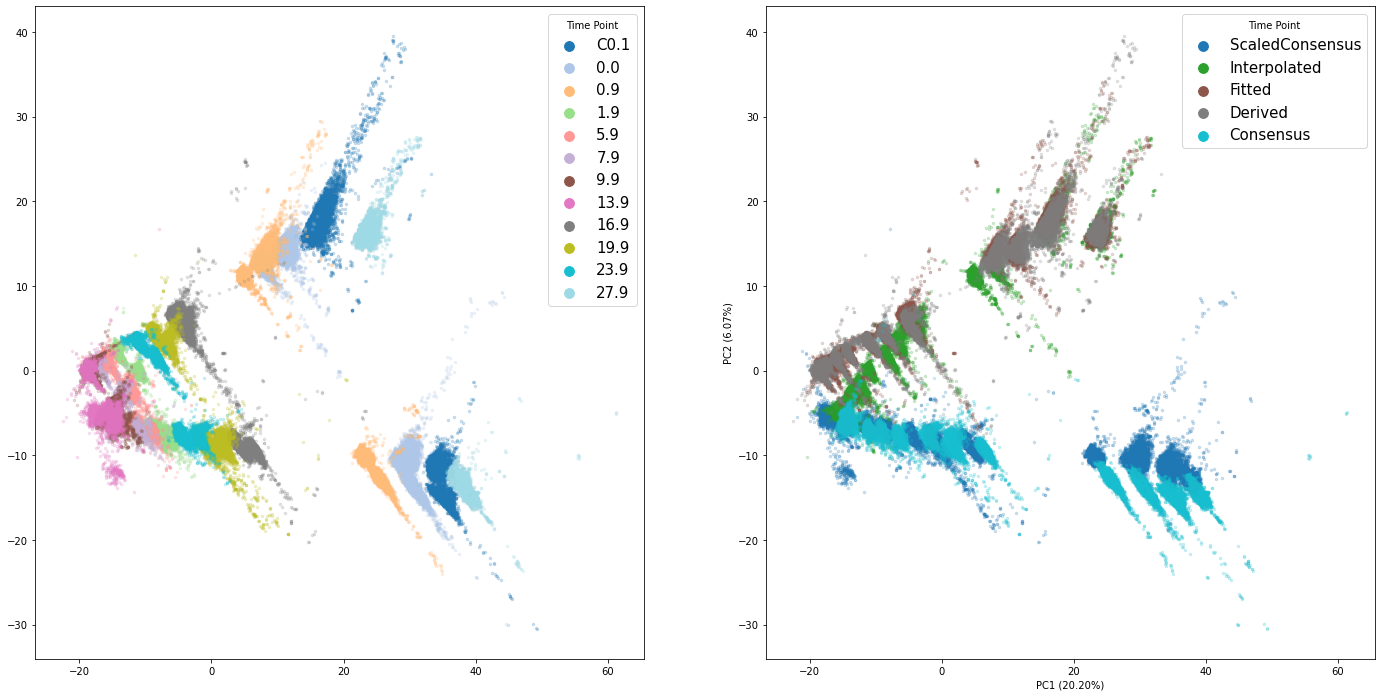

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets, preprocessing

dyn_x = norm_chains_df


x = dyn_x.values
x[np.isnan(x)] = 0
x = StandardScaler().fit_transform(x)
# normalised_x = pd.DataFrame(x,columns=norm_dyn_x.iloc[:,4:].columns)


pca_x = PCA()
principalComponents_x = pca_x.fit_transform(x)

print('Explained variation per principal component: {}'.format(pca_x.explained_variance_ratio_))

le = preprocessing.LabelEncoder()

# y = le.fit_transform(norm_chains_df.index.get_level_values("Time")) 
# targets = norm_chains_df.index.get_level_values("Time").unique().to_list() # columnsdyn_x["Time"].unique()

y = le.fit_transform(dyn_x.reset_index()["Time"])
targets = dyn_x.reset_index()["Time"].unique()

# y = le.fit_transform(dyn_x.reset_index()["Equation"])
# targets = dyn_x.reset_index()["Equation"].unique()


# features = norm_chains_df.columns 
features = dyn_x.columns 

cmap = plt.cm.get_cmap('tab20', len(targets))
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    
# coordinates of samples (i.e., scores; let's take the first two axes)
scores = principalComponents_x[:, :2]

# coordinates of features (i.e., loadings; note the transpose)
loadings = pca_x.components_[:2].T

# proportions of variance explained by axes
pvars = pca_x.explained_variance_ratio_[:2] * 100

k=len(features)//80
tops = (loadings ** 2).sum(axis=1).argsort()[-k:]
arrows = loadings[tops]
arrows /= np.sqrt((arrows ** 2).sum(axis=0))
arrows *= np.abs(scores).max(axis=0)

fig, axes = plt.subplots(ncols=2,figsize=(24,12))
# plt.figure(figsize=(12, 12))
for i, name in enumerate(targets):
    axes[0].scatter(*zip(*scores[y == i]), label=name, s=6, alpha=0.2,c=color_list[i])
    
legend = axes[0].legend(title='Time Point',fontsize=15,markerscale=4)
[h.set_alpha(1) for h in legend.legendHandles]

# width = -0.0005 * np.min([np.subtract(*plt.xlim()), np.subtract(*plt.ylim())])
# for i, arrow in zip(tops, arrows):
#     plt.arrow(0, 0, *arrow, color='k', alpha=0.75, width=width, ec='none',
#               length_includes_head=True)
#     plt.text(*(arrow * 1.15), features[i], ha='center', va='center')

for i, axis in enumerate('xy'):
    # getattr(plt, f'{axis}ticks')([])
    getattr(plt, f'{axis}label')(f'PC{i + 1} ({pvars[i]:.2f}%)')
    
    
## Take the top 5% of features explaining PC1
print(features[(pca_x.components_[0].T ** 2).argsort()[-len(features)//20:]])

# take the top 5% of all features
print(features[tops])

le = preprocessing.LabelEncoder()

# y = le.fit_transform(norm_chains_df.index.get_level_values("Equation").to_series())
# targets = norm_chains_df.index.get_level_values("Equation").unique().to_list() # norm_chains_df["Equation"].unique()

y = le.fit_transform(dyn_x.index.get_level_values("Equation").to_series())
targets = dyn_x.reset_index()["Equation"].unique()


# features = norm_chains_df.columns 
features = dyn_x.columns

cmap = plt.cm.get_cmap('tab10', len(targets))
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    
# coordinates of samples (i.e., scores; let's take the first two axes)
scores = principalComponents_x[:, :2]

# coordinates of features (i.e., loadings; note the transpose)
loadings = pca_x.components_[:2].T

# proportions of variance explained by axes
pvars = pca_x.explained_variance_ratio_[:2] * 100

k=len(features)//80
tops = (loadings ** 2).sum(axis=1).argsort()[-k:]
arrows = loadings[tops]
arrows /= np.sqrt((arrows ** 2).sum(axis=0))
arrows *= np.abs(scores).max(axis=0)

for i, name in enumerate(targets):
    axes[1].scatter(*zip(*scores[y == i]), label=name, s=6, alpha=0.2,c=color_list[i])
    
legend = axes[1].legend(title='Time Point',fontsize=15,markerscale=4)
[h.set_alpha(1) for h in legend.legendHandles]

# width = -0.0005 * np.min([np.subtract(*plt.xlim()), np.subtract(*plt.ylim())])
# for i, arrow in zip(tops, arrows):
#     plt.arrow(0, 0, *arrow, color='k', alpha=0.75, width=width, ec='none',
#               length_includes_head=True)
#     plt.text(*(arrow * 1.15), features[i], ha='center', va='center')

for i, axis in enumerate('xy'):
    # getattr(plt, f'{axis}ticks')([])
    getattr(plt, f'{axis}label')(f'PC{i + 1} ({pvars[i]:.2f}%)')
    
    
## Take the top 5% of features explaining PC1
print(features[(pca_x.components_[0].T ** 2).argsort()[-len(features)//20:]])

# take the top 5% of all features
print(features[tops])

fig.savefig("../results/plots/PCA.png", dpi=300)